# **Chinese Character Digit Classification using Deep Neural Networks**

## **Table of Contents**

*   [Introduction](#introduction)
*   [Methodology](#methodology)
> *   [Defining the problem and assembling a dataset](#definition)
> *   [Choosing a measure of success](#measure)
> *   [Deciding on the evaluation protocol](#protocol)
> *   [Preparing the dataset](#preparation)
>> *   [Loading and analysing the distribution of data](#loading)
>> *   [Helper functions for pre-processing data](#preprocessing_helper)
>> *   [Pre-processing the data](#preprocessing)
>> *   [Helper functions for structuring the model](#model_helper)
>> *   [Helper functions for data augmentation](#augmentation_helper)
> *   [Developing a model that does better than the baseline](#baseline)
> *   [Scaling up: Developing a model that overfits](#overfitting)
> *   [Regularising the model and tuning the hyperparameters](#regularisation)
*   [Results](#results)
> *   [Summary of final production model](#summary)
> *   [Final production model evaluation](#evaluation)
> *   [Final production model predictions](#predictions)
*   [Conclusion](#conclusion)
*   [References](#references)



## **Introduction** <a id="introduction"></a>

This report intends to follow the universal workflow of DLWP using the Chinese Numbers MNIST Dataset from Kaggle, to perform Deep Learning for Computer Vision and build successions of the model so it can accurately predict the Chinese number characters. 

The Chinese Numbers MNIST Dataset is a multi-class image classification problem, commonly used in deep learning and computer vision. The dataset contains 15,000 images in total, with each image sized at 64x64 and representing a Chinese number e.g., 0-10, 100, 1000, 10000, or 100000000. There are 15 Chinese characters in total which mean each character has 1000 images, and therefore proves that the dataset is balanced and clean. Throughout this report, I will be systematically experimenting with the Chinese Numbers MNIST dataset using convnets to find the best convnet model, with the techniques from DLWP part 2. The DLWP workflow will comprise of 7 steps: defining the problem and assembling a dataset, choosing a measure of success, deciding on the evaluation protocol, preparing the dataset, developing a model that does better than the baseline, scaling up by developing a model that overfits, and regularising the model as well as tuning the hyperparameters. 

The techniques I intend to use will mainly be from topic 5, which include fine-tuning the model, feature extraction, adding regularization (e.g., dropout layers) and tuning the hyperparameters (e.g., experimenting with different activation functions, kernel sizes, number of layers, number of filters per convolution layer, optimizer functions and tuning the learning rate). I also intend to use advanced best practices from topic 7 e.g., batch normalisation, and depth-wise separable convolution. Finally, after completing the systematic experiment and reporting all my findings, I will be evaluating the best model for its optimal epochs and comparing it against the baseline model.

## **Methodology** <a id="methodology"></a>

### **Defining the Problem and Assembling a Dataset** <a id="definition"></a>

The main focus of this research is classifying the handwritten Chinese character digits as numeric values. The dataset being assembled is an MNIST based on Chinese character numbers, consisting of 15,000 64x64 images of Chinese characters. The data is split into 15 classes with a single label, each of which has 1000 images and represent a Chinese number:

* 1:	零 = 0
* 2:	一 = 1
* 3:	二 = 2
* 4:	三 = 3
* 5:	四 = 4
* 6:	五 = 5
* 7:	六 = 6
* 8:	七 = 7
* 9:	八 = 8
* 10:	九 = 9
* 11:	十 = 10
* 12:	百 = 100
* 13:	千 = 1000
* 14:	万 = 10000
* 15:	亿 = 100000000

The aim of this research is to investigate whether a deep learning model can be built and trained on the Chinese Numbers MNIST dataset, so it can accurately classify a handwritten Chinese number as a numeric value. The problem being faced at hand is a multi-class single-label classification problem since the image of a Chinese character belongs to one of the 15 classes. After defining the problem type, I now have an idea of suitable model architecture, loss function, optimiser, and the activation function for the last hidden layer. I can hypothesise that the outputs can be predicted based on the given inputs and that the availability of data is adequately useful to study the relationship between the inputs and outputs.

### **Choosing Measure of Success** <a id="measure"></a>

The measure of success which will be used in this research is classification accuracy. This involves the model making a prediction for each input in the dataset and comparing them against the label in the dataset. The accuracy is then measured by the number of correct predictions divided by the number of overall predictions:

***Accuracy = Correct Predictions ÷ Total Predictions***

The Chinese Numbers MNIST dataset is clearly a multi-class single-label classification problem since there are multiple classes each with a single label. Therefore, the choice of the loss function to be adopted for this problem is `categorical_crossentropy` as well as the accuracy metric since accuracy is being measured. 

### **Deciding on an Evaluation Protocol** <a id="protocol"></a>

When creating a neural network/deep learning network, there are three common evaluation protocols that are to be decided on to minimise the risk of overfitting. These include: 
* Maintaining hold-out validation set - this is ideal when you have good availability of data
* Performing K-fold cross-validation – this is ideal when you have very few samples of data, making the hold-out validation a less reliable protocol
* Performing iterated K-fold validation – this is ideal when you are doing a highly accurate model evaluation with low availability of data

Since the Chinese MNIST dataset has a large availability of data of 15,000 image samples, it only makes sense to use hold-out validation. In order to have a good deep learning workflow, it is important to start off with a small model and then go on to scaling it up until the model overfits. This will then put in place other systems of measure such as regularisation (e.g., adding dropout layers) or tuning the learning rate until the overfitting is reduced and an optimal model is achieved.
After deciding to choose the hold-out validation set protocol, it meant that the Chinese MNIST dataset had to be split into three sub-datasets: training, validation, and testing. Out of the 15,000 samples, 9600 samples were extracted to construct the training set and 2400 samples were extracted to construct the validation set which left 3000 samples for testing and evaluating the final model on unseen data. I believe that utilising a validation set would be beneficial during each iteration of developing and training the model, as it enables metrics such as loss and accuracy to be displayed for both the training and validation data. The benchmark data produced after fitting the model are then helpful in the decision-making process of tuning the model to improve its accuracy, eventually leading to an optimal model.

### **Preparing the Chinese MNIST Dataset** <a id="preparation"></a>

Now that dataset has been established along with the problem at hand, the aim for optimisation and the evaluation protocol, it is almost time to train the model. The only step remaining is pre-processing the Chinese MNIST dataset and structuring the convnet model. The cell below shows all the dependencies that will be required to prepare the data for training.


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform

from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from prettytable import PrettyTable

### **Loading and Analysing the Distribution of Data within the Dataset** <a id="loading"></a>

As shown on the cell below, the dataset is being imported externally via CSV file which was downloaded from Kaggle. This dataset has been saved on Google Drive, allowing easy access simply by copying the path and reading it through a Data Frame. 

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/chinese-mnist/chinese_mnist.csv")
df.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


The cell below shows the distribution of data for each Chinese character. The output states that there are a total of 15 characters, each with 1000 images. This shows that the dataset is clean and has the correct number of samples for each class.

In [ ]:
print("Distribution of data per chinese character:\n{}".format(df[['code','character','value']].value_counts()))

Distribution of data per chinese character:
code  character  value    
15    亿          100000000    1000
14    万          10000        1000
13    千          1000         1000
12    百          100          1000
11    十          10           1000
10    九          9            1000
9     八          8            1000
8     七          7            1000
7     六          6            1000
6     五          5            1000
5     四          4            1000
4     三          3            1000
3     二          2            1000
2     一          1            1000
1     零          0            1000
dtype: int64


As you can see from the Pie Chart visualisation of each class below, the dataset is clearly balanced as each class has the same number of character samples.Therefore, it is clear that there is no need for carrying out extra techniques such as data augmentation or pruning.

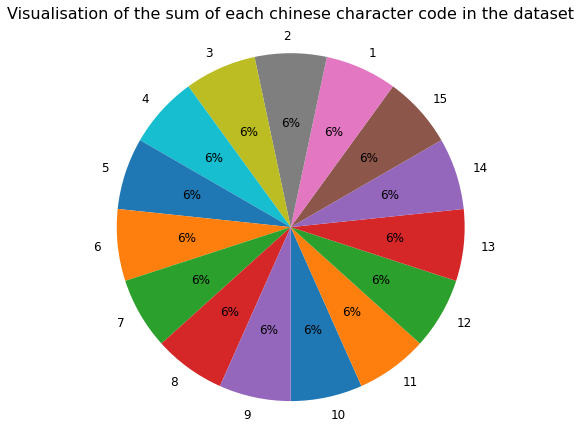

<Figure size 720x720 with 0 Axes>

In [ ]:
pie_vals = np.array(df['character'].value_counts())
plt.pie(pie_vals, labels=df.code.unique(), radius=2, autopct="%.0d%%", startangle=270, textprops={"fontsize":12})
plt.title("Visualisation of the sum of each chinese character code in the dataset", size=16, pad=100)
plt.figure(figsize=[10,10])
plt.show()

### **Helper Functions for Pre-Processing Data** <a id="preprocessing_helper"></a>

The cell below represents all the helper functions to easily carry out the pre-processing of data, without having to repeat code. These include:

*   `display_sample_image(img)` - displays a sample image from its respective sample dataset
*   `read_image_size(sample_name)` - retrieves the sizes of all the sample images in the dataset
*   `read_image(sample_name)` - normalises the images for readability of sample images by transforming them so they are resized with only 1 channel (like a grayscale image)
*   `character_encoder(df)` - one hot encodes all 15 Chinese characters categorically with dummy variables (0s and 1s), making the training data more useful for training
*   `visualise_model(model)` - displays a visual representation of the model architecture
*   `get_model_history(history)` - retrieves all history keys of the model 
*   `plot_model_history(history, name="")` - plots both the model loss and accuracy





In [ ]:
# displays the sample image from its respective sample dataset
def display_sample_image(img):
  img = img.reshape(64, 64)
  plt.imshow(img, cmap="gray")

# retrieves the size of all the sample images in the dataset
def read_image_size(sample_name):
    img = skimage.io.imread("/content/drive/MyDrive/chinese-mnist/data/" + sample_name)
    return list(img.shape)

# normalises the images for readability of sample images by transforming them so they are resized with only 1 channel (like a grayscale image)
def read_image(sample_name):
    img = skimage.io.imread("/content/drive/MyDrive/chinese-mnist/data/" + sample_name)
    img = skimage.transform.resize(img, (64, 64, 1), mode = "reflect") # mode = "reflect" represents a type of edge mode during interpolation
    return img[:, :, :] # returns the shape values of the image by slicing the width, height, channel

# one hot encodes all 15 Chinese characters categorically with dummy variables (0s and 1s), making the training data more useful for training
def character_encoder(df):
    x = np.stack(df["sample_name"].apply(read_image))
    y = pd.get_dummies(df["character"]) # creates dummy variables for the character column in the dataframe
    return x, y

# plots the model architecture
def visualise_model(model):
  return plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

# retrieves all history keys of the model
def get_history_keys(history):
  return (history.history,
          history.history["loss"],
          history.history["val_loss"], 
          history.history["accuracy"],
          history.history["val_accuracy"])

# plots both the model loss and accuracy
def plot_model_history(history, name=""):
  history_dict, loss, val_loss, acc, val_acc = get_history_keys(history) # get histories
  epochs = range(1, len(loss) + 1)
  blue_dots = 'bo'
  solid_blue_line = 'b'

  # defining the history subplots 
  values, axis = plt.subplots(1, 2)
  values.suptitle(f"Results for {name}", fontsize=14)
  values.set_size_inches(14, 6)

  # plotting the values on the axis for each subplot
  axis[0].plot(epochs, loss, blue_dots, label = 'Training loss')
  axis[0].plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
  axis[1].plot(epochs, acc, blue_dots, label = 'Training acc')
  axis[1].plot(epochs, val_acc, solid_blue_line, label = 'Validation acc')

  # defining the labels
  plt.setp(axis[0], xlabel='Epochs')
  plt.setp(axis[0], ylabel='Loss')
  plt.setp(axis[1], xlabel='Epochs')
  plt.setp(axis[1], ylabel='Accuracy')
  axis[0].set_title('Training and validation loss')
  axis[0].legend()
  axis[1].set_title('Training and validation acc')
  axis[1].legend()

### **Pre-Processing the Data** <a id="preprocessing"></a>

The cell below creates a new column in the dataframe by calling the `column_sample_name` helper function. Since each input sample has been distinctively named by following the naming convention of their respective `suite_id`, `sample_id` and `code` from the dataframe rows, the helper function simply take those values and joins them together using formatted string literals split with underscores. Once the column has been created, the first five rows of the data frame are displayed below:

In [ ]:
# this will return a formatted string containing the name of each sample, e.g. input_1_1_10.jpg   
def column_sample_name(df):
    return f"input_{df[0]}_{df[1]}_{df[2]}.jpg"

# creating a sample_name column
df["sample_name"] = df.apply(column_sample_name, axis=1)
df.head()    

,suite_id,sample_id,code,value,character,sample_name
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg


The cell below is checking that the data in the `sample_name` column matches all the image file names in the dataset. We can see that the similarities are 15,000 which are exactly the total number of image samples in the dataset. Therefore, we can say that the image file names and the data in the `sample_name` column are identical.

In [ ]:
all_img = os.listdir("/content/drive/MyDrive/chinese-mnist/data/") # retrieves the file path for all image samples

sample_names = list(df.sample_name) # checking the same file names in the sample_name column
print("Similarities: {}".format(len(set(sample_names).intersection(all_img)))) # the intersection method checks the number of similarities between two items

Similarities: 15000


The cell below retrieves the images sample sizes using the helper function and stacks them onto an array of columns in a temporary dataframe for both the width and height of each image sample. These columns are then concatenated with the main dataframe, enabling the data to be prepared for training.

In [ ]:
img_sizes = np.stack(df.sample_name.apply(read_image_size))
size_df = pd.DataFrame(img_sizes, columns=["width", "height"])

df = pd.concat([df, size_df], axis = 1)
df.head(5)

,suite_id,sample_id,code,value,character,sample_name,width,height
0,1,1,10,9,九,input_1_1_10.jpg,64,64
1,1,10,10,9,九,input_1_10_10.jpg,64,64
2,1,2,10,9,九,input_1_2_10.jpg,64,64
3,1,3,10,9,九,input_1_3_10.jpg,64,64
4,1,4,10,9,九,input_1_4_10.jpg,64,64


The cell below shows the intialisation of the split between training and testing as well as the intialisation of the training and validation data.

In [ ]:
# initialising the split between training and testing
df_train, df_test = train_test_split(df, test_size=0.2)

# initialising the training and validation data
df_train, df_val = train_test_split(df_train, test_size=0.2)

The cell below is transforming all the sample images so they are resized with only 1 channel. This means that all images are being converted to grayscale images. We can confirm this by looking at the shape of the image below (64, 64, 1).

In [ ]:
img = skimage.io.imread("/content/drive/MyDrive/chinese-mnist/data/" + df.sample_name[3])
print(img.shape)
img = skimage.transform.resize(img, (64, 64, 1), mode="reflect")
print(img.shape)

(64, 64)
(64, 64, 1)


The cell below uses the `character_encoder()` helper function to categorically one-hot encode all the characters in the training, validation, and testing sub-datasets. This makes the training data more useful as it allows for deterministic predictions. We can also see the ratio between the training, validation and testing samples as shown below:

In [ ]:
train_x, train_y = character_encoder(df_train)
val_x, val_y = character_encoder(df_val)
test_x, test_y = character_encoder(df_test)

# displaying the training/validation/testing split
print("Training Samples:", train_x.shape, ", Training Labels:", train_y.shape)
print("Validation Samples:", val_x.shape, ", Validation Labels:", val_y.shape)
print("Testing Samples:", test_x.shape, ", Testing Labels:", test_y.shape)

Training Samples: (9600, 64, 64, 1) , Training Labels: (9600, 15)
Validation Samples: (2400, 64, 64, 1) , Validation Labels: (2400, 15)
Testing Samples: (3000, 64, 64, 1) , Testing Labels: (3000, 15)


The cell below displays a sample image from the training dataset using the `display_sample_image()` helper function. This allows us to get a visual representation on what samples are being used to train the model.

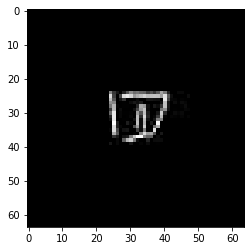

In [ ]:
display_sample_image(train_x[random.randint(0, len(train_x))])

### **Helper Functions for Structuring the Model** <a id="model_helper"></a>

The cell below represents all the helper functions to easily construct a model for experimentation, without having to repeat code. These include:

*   `surpass_baseline_model()` - constructs a simple model for the purpose of beating the dumb baselin
*   `construct_overfitted_model()` - constructs a scaled up model from the simple model, for the purpose of achieving overfitting
*   `construct_tuned_model(kernel_size, activation_fx, optimiser)` - constructs a model to tune the hyperparameters through parameterised inputs
*   `construct_regularised_model(filters, dropout)` - constructs a model to tune the hyperparameters add dropouts through parameterised inputs
*   `train_model(model, epoch)` - returns a model.fit() function with parameterised inputs i.e. the number of epochs, to carry out the training process

In [ ]:
def surpass_baseline_model():
  model = models.Sequential()
  model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(8, activation='relu'))
  model.add(layers.Dense(15, activation='softmax'))
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
def construct_overfitted_model():
  model = models.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(15, activation='softmax'))
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
def construct_tuned_model(kernel_size, activation_fx, optimiser):
  model = models.Sequential()
  model.add(layers.Conv2D(64, kernel_size, activation=activation_fx, input_shape=(64, 64, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, kernel_size, activation=activation_fx))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, kernel_size, activation=activation_fx))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation=activation_fx))
  model.add(layers.Dense(15, activation='softmax'))
  model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
def construct_regularised_model(filters, dropout):
  model = models.Sequential()
  model.add(layers.Conv2D(filters[0], (5, 5), activation='tanh', input_shape=(64, 64, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(filters[1], (5, 5), activation='tanh'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(dropout))
  model.add(layers.Conv2D(filters[2], (5, 5), activation='tanh'))
  model.add(layers.Flatten())
  model.add(layers.Dense(filters[3], activation='tanh'))
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(15, activation='softmax'))
  model.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
# helper function for training the model i.e. running for epochs
def train_model(model, epoch):  
  callbacks_list = [
                    EarlyStopping( # if the model doesn't improve its validation accuracy for up to 5 epochs, it will stop training
                        monitor='val_accuracy',
                        patience=5, # represents the number of epochs with no improvement to which the training will be terminated
                        ),
                    ModelCheckpoint( # if the model reaches an optimal validation loss, it will be saved onto the directory so it can be loaded later
                        filepath='best-model.h5',
                        verbose=1,
                        monitor='val_loss',
                        save_best_only=True,
                        )
                    ]
  # model_checkpoint = ModelCheckpoint(filepath='optimum-model.h5', verbose = 1, save_best_only=True)
  return model.fit(train_x, 
                   train_y,
                   epochs = epoch,
                   batch_size = 64,
                   callbacks=callbacks_list,
                   validation_data = (val_x, val_y))

### **Helper Functions for Data Augmentation** <a id="augmentation_helper"></a>

The cell below represents all the helper functions to easily construct a model for data augmentation, without having to repeat code. These include:

*   `get_augmented_generator(train_datagen)` - retrives a data augmentation generator with parameterised inputs
*   `train_augmented_model(model, train_datagen, epoch)` - returns a model.fit_generator() function with parameterised inputs i.e. the number of epochs, to carry out the training process with data augmentation

In [ ]:
# helper function for retrieving a data augmentation generator
def get_augmented_generator(train_datagen):
  return train_datagen.flow(train_x, train_y, batch_size=64)

In [ ]:
# helper function for training the model with the data augmentation generator
def train_augmented_model(model, train_datagen, epoch):  
  callbacks_list = [
                    
                    EarlyStopping( # if the model doesn't improve its validation accuracy for up to 5 epochs, it will stop training
                        monitor='val_accuracy',
                        patience=5, # represents the number of epochs with no improvement to which the training will be terminated
                        ),
                    ModelCheckpoint( # if the model reaches an optimal validation loss, it will be saved onto the directory so it can be loaded later
                        filepath='best-model.h5',
                        verbose=1,
                        monitor='val_loss',
                        save_best_only=True,
                        )
                    ]

  return model.fit(get_augmented_generator(train_datagen),
                   epochs = epoch,
                   callbacks=callbacks_list,
                   validation_data = (val_x, val_y))

### **Developing a model that does better than the baseline** <a id="baseline"></a>

The baseline was built upon the goal of proving the hypotheses stated at the beginning, predicting outputs based on the given inputs as well as having sufficient data to learn the relationship between the inputs and outputs. After calculating the dumb baseline model (1 ÷ number of classes x 100) which produced an accuracy of 6.6666666667, it was clear that to achieve statistical power and prove my hypotheses, I had to construct a model that achieved more than 6% accuracy to surpass common sense in classifying handwritten Chinese characters. In the case of the scaled-up model not being able to beat the baseline, it could be that the hypotheses were proven to be false.

I began by building the model using the sequential model architecture as it is a popular architecture for classification problems. The model consisted of three 2D convolutional layers, each with 16 neurons, a kernel size of 3, and a `relu` activation function. The model also had two dense layers, with the first layer comprising of 8 neurons with a `relu` activation, and the last layer comprising of 15 neurons with a `softmax` activation function. The reason why the last layer had a ‘softmax’ activation function is due to the Chinese MNIST dataset being a multi-class classification problem, thus the last layer would require 15 outputs as there are 15 classes.

The next step was to choose the optimiser function. For this problem, I chose `rmsprop` with the default learning rate. Optimiser functions are capable of having adjustable learning rates to reduce the risk of having a high loss. The loss function used was `categorical_crossentropy`, which as previously mentioned, is ideal for this multi-class classification problem as the model is only working with 15 classes providing a greater chance of achieving low loss and high accuracy. Finally, the metric used was `accuracy` since we are trying to measure accuracy.

Once the foundations of the model had been built and compiled, it was then trained on the training set containing 9600 samples and 2400 validation samples, for 30 epochs and a batch size of 64. The `validation_data` parameter represented the validation dataset containing the metrics for both loss and accuracy.

### **Model 1 - Beating the dumb baseline**

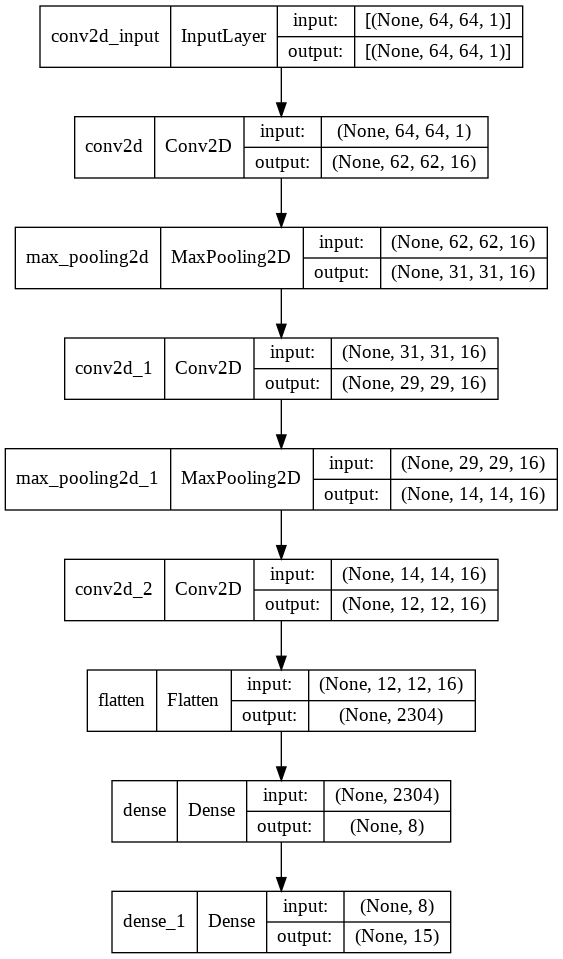

In [ ]:
visualise_model(surpass_baseline_model())

In [ ]:
history = train_model(surpass_baseline_model(), 30)

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 2.5112 - accuracy: 0.1458
Epoch 00001: val_loss improved from inf to 2.28335, saving model to optimum-model.h5
150/150 [==============================] - 25s 162ms/step - loss: 2.5112 - accuracy: 0.1458 - val_loss: 2.2833 - val_accuracy: 0.2496
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 1.9551 - accuracy: 0.3620
Epoch 00002: val_loss improved from 2.28335 to 1.68381, saving model to optimum-model.h5
150/150 [==============================] - 22s 148ms/step - loss: 1.9551 - accuracy: 0.3620 - val_loss: 1.6838 - val_accuracy: 0.4292
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 1.4070 - accuracy: 0.5329
Epoch 00003: val_loss improved from 1.68381 to 1.18756, saving model to optimum-model.h5
150/150 [==============================] - 22s 146ms/step - loss: 1.4070 - accuracy: 0.5329 - val_loss: 1.1876 - val_accuracy: 0.6263
Epoch 4/30
150/150 [===========================

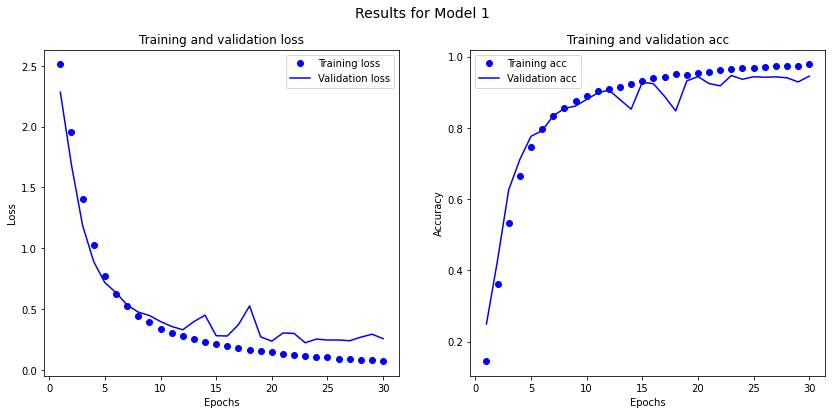

In [ ]:
plot_model_history(history, name="Model 1")

#### **Summary of Model 1**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |


The outputs from the initial model shows that it was able to achieve an optimal validation accuracy of 0.9467 and a validation loss of 0.2221 at 23 epochs. This clearly indicates that the model has achieved statistical power, since it beat the dumb baseline accuracy of 6.66%. However, the performance wasn't too great since there were clear signs of overfitting - the validation loss and accuracy started to become unstable after the 23rd epoch.

### **Scaling up: Developing a model that overfits** <a id="overfitting"></a>

The first model iteration successfully beat the dumb baseline by achieving an accuracy of 94%, however, it wasn’t the ideal model as there were clear signs of overfitting in the model. Although there were enough 2D convolutional and dense layers, the model started to become unstable after its accuracy peaked. Therefore, in order to develop its succession, I decided to scale up the model by increasing the filters for both the 2D convolutional and dense layers to solve the overfitting problem. This would most likely improve the stability of the model as it would increase its capacity to work with more data. I have also decided to continue training the model at 30 epochs since it is enough to achieve a line of best fit. The ideal model to be achieved is a model that neither overfits nor underfits. If the model continues to overfit and become unstable, I will need to implement additional techniques such as regularisation and tuning the hyperparameters.

### **Model 2 - Increase the filters for each conv2D and dense layer**

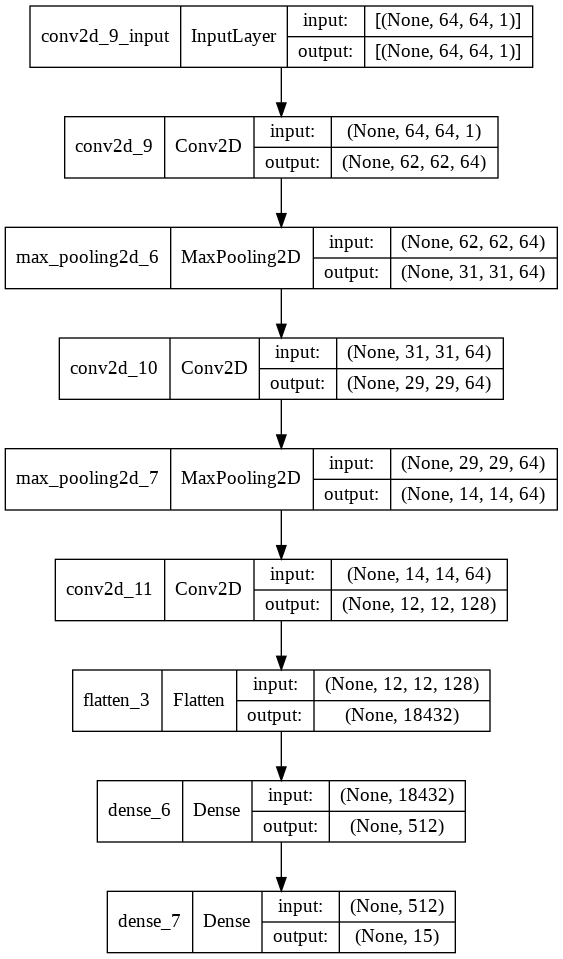

In [ ]:
visualise_model(construct_overfitted_model())

In [ ]:
history = train_model(construct_overfitted_model(), 30)

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 0.8999 - accuracy: 0.7127
Epoch 00001: val_loss improved from inf to 0.36671, saving model to optimum-model.h5
150/150 [==============================] - 114s 753ms/step - loss: 0.8999 - accuracy: 0.7127 - val_loss: 0.3667 - val_accuracy: 0.8800
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.2249 - accuracy: 0.9251
Epoch 00002: val_loss improved from 0.36671 to 0.16920, saving model to optimum-model.h5
150/150 [==============================] - 113s 753ms/step - loss: 0.2249 - accuracy: 0.9251 - val_loss: 0.1692 - val_accuracy: 0.9483
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.9669
Epoch 00003: val_loss improved from 0.16920 to 0.14269, saving model to optimum-model.h5
150/150 [==============================] - 112s 746ms/step - loss: 0.1016 - accuracy: 0.9669 - val_loss: 0.1427 - val_accuracy: 0.9642
Epoch 4/30
150/150 [========================

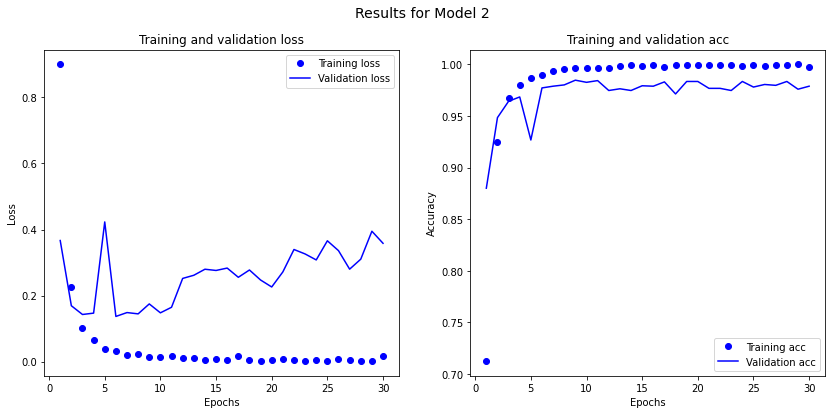

In [ ]:
plot_model_history(history, name="Model 2")

#### **Summary of Model 2**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |


The outputs from model 2 shows that the model has successfully been scaled up,as validation accuracy was able to improve from increasing the filters for each conv2D and dense layer. However, the graph plot clearly shows that overfitting has still occured as the validation loss drastically increased after epoch 6. This means that the model is not performing well on the given data as it is producing errors due to the high loss. Therefore, we must now carry out extra measures to reduce overfitting such as, regularisation and tuning the hyperparameters.

### **Regularising the model and tuning the hyperparameters** <a id="regularisation"></a>

After scaling up the model and increasing the filters for each layer, it was evident that the model was still overfitting. This meant that the model needed to implement regularisation and tuning of the hyperparameters, to mitigate any risk of overfitting. The goal is to achieve an optimal model, where it doesn’t overfit nor underfit. There are numerous methods for regularising a model and tuning hyperparameters, these include:
-	Tuning the learning rate
-	Adding Dropout Layers
-	Increasing/Decreasing the filters for each conv2D and dense layer
-	Applying Data Augmentation
-	Applying Batch Normalisation
-	Applying Fine-tuning
-	Applying Feature extraction

The next few iterations of the model will tune the hyperparameter by adjusting the learning rate of the optimiser function. This will not only reduce the chances of the model overfitting but also have an effect on how quickly the model can arrive at its best accuracy whilst maintaining a low loss.

### **Model 3 - Tune the learning rate to 0.0001**

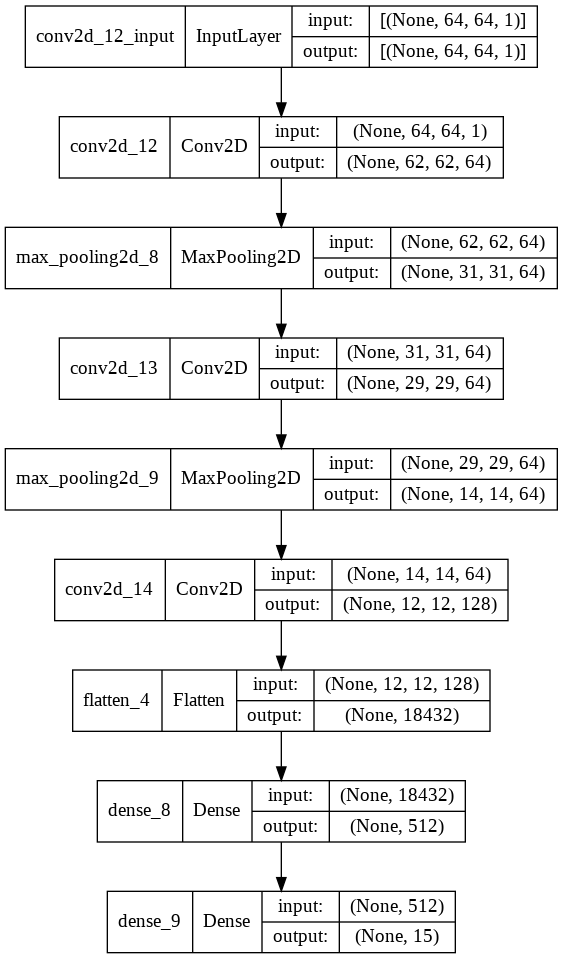

In [ ]:
visualise_model(construct_tuned_model((3, 3), 'relu', optimizers.RMSprop(learning_rate=0.0001)))

In [ ]:
history = train_model(construct_tuned_model((3, 3), 'relu', optimizers.RMSprop(learning_rate=0.0001)), 30)

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 1.7661 - accuracy: 0.4640
Epoch 00001: val_loss improved from inf to 1.40143, saving model to optimum-model.h5
150/150 [==============================] - 101s 664ms/step - loss: 1.7661 - accuracy: 0.4640 - val_loss: 1.4014 - val_accuracy: 0.5708
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.9590 - accuracy: 0.7058
Epoch 00002: val_loss improved from 1.40143 to 0.81900, saving model to optimum-model.h5
150/150 [==============================] - 99s 662ms/step - loss: 0.9590 - accuracy: 0.7058 - val_loss: 0.8190 - val_accuracy: 0.7400
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.5888 - accuracy: 0.8168
Epoch 00003: val_loss improved from 0.81900 to 0.51975, saving model to optimum-model.h5
150/150 [==============================] - 99s 661ms/step - loss: 0.5888 - accuracy: 0.8168 - val_loss: 0.5198 - val_accuracy: 0.8471
Epoch 4/30
150/150 [==========================

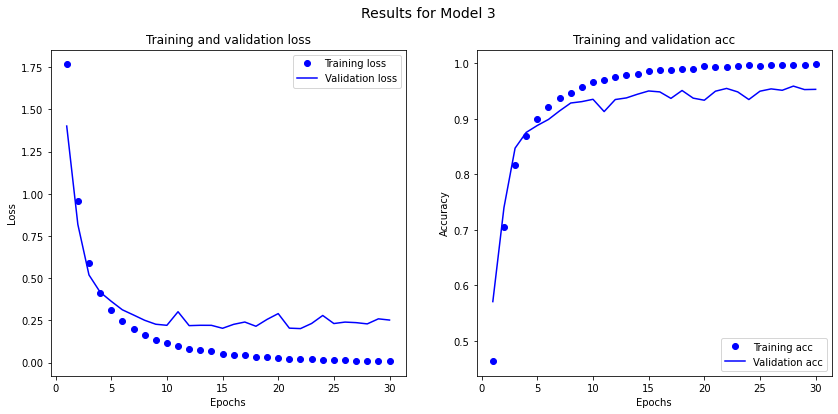

In [ ]:
plot_model_history(history, name="Model 3")

#### **Summary of Model 3**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |
| 3 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0001 | 0.2020 | 0.9546 | Although the accuracy has slightly decreased, the loss has stabilised. However, there are still signs of overfitting |


The outputs from model 3 that tuning the learning rate has stabilise the validation loss by keeping gradually decreasing it. However, this has led to a decrease in the validation accuracy as it has now dropped to 0.9546 as shown on the table above, which could mean the model not making any progress to reach a local minima. Therefore, I have decided to slightly increase the learning rate to 0.0005 to see reach a local minima.

### **Model 4 - Tune the learning rate to 0.0005**

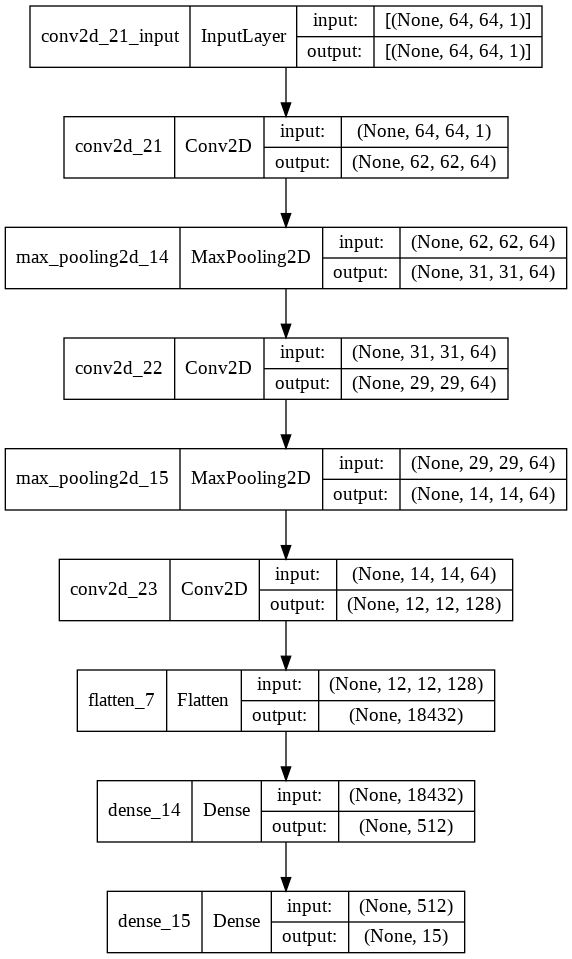

In [ ]:
visualise_model(construct_tuned_model((3, 3), 'relu', optimizers.RMSprop(learning_rate=0.0005)))

In [ ]:
history = train_model(construct_tuned_model((3, 3), 'relu', optimizers.RMSprop(learning_rate=0.0005)), 30)

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 1.0280 - accuracy: 0.6748
Epoch 00001: val_loss improved from inf to 0.44054, saving model to optimum-model.h5
150/150 [==============================] - 113s 750ms/step - loss: 1.0280 - accuracy: 0.6748 - val_loss: 0.4405 - val_accuracy: 0.8546
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.8893
Epoch 00002: val_loss improved from 0.44054 to 0.32503, saving model to optimum-model.h5
150/150 [==============================] - 113s 757ms/step - loss: 0.3408 - accuracy: 0.8893 - val_loss: 0.3250 - val_accuracy: 0.8829
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.1922 - accuracy: 0.9390
Epoch 00003: val_loss improved from 0.32503 to 0.28288, saving model to optimum-model.h5
150/150 [==============================] - 114s 757ms/step - loss: 0.1922 - accuracy: 0.9390 - val_loss: 0.2829 - val_accuracy: 0.9096
Epoch 4/30
150/150 [========================

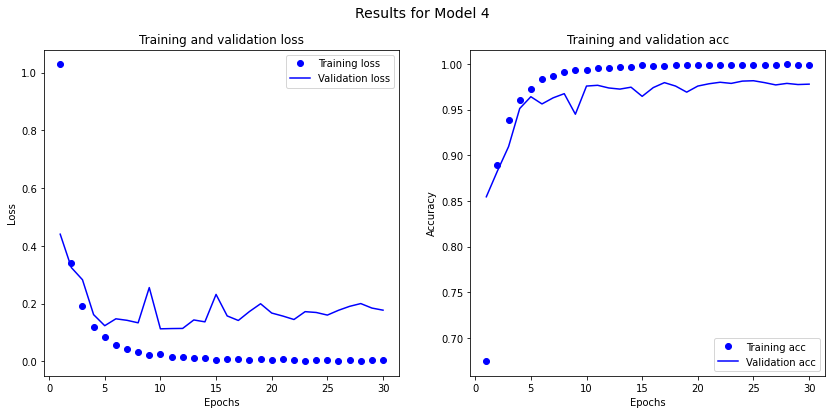

In [ ]:
plot_model_history(history, name="Model 4")

#### **Summary of Model 4**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |
| 3 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0001 | 0.2020 | 0.9546 | Although the accuracy has slightly decreased, the loss has stabilised. However, there are still signs of overfitting |
| 4 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0005 | 0.1130 | 0.9758 | Increasing the learning rate has sacrificed the stability of the loss, but the validation loss decreased and validation accuracy increased |


The outputs from model 4 shows that increasing the learning rate has managed to decrease the validation loss to 0.1130 and increase the validation accuracy to 0.9758 at epoch 10. This is a good improvement as we have managed to achieve a local minima.

Although the validation loss has decreased, it started to fluctuate and become unstable which resulted in overfitting as illustrated on the graph plots. I will now further tune the learning rate by decreasing it to 0.00025. I believe doing this will reduce the fluctuations whilst maintaining a low validation loss.

### **Model 5 - Tune the learning rate to 0.00025**

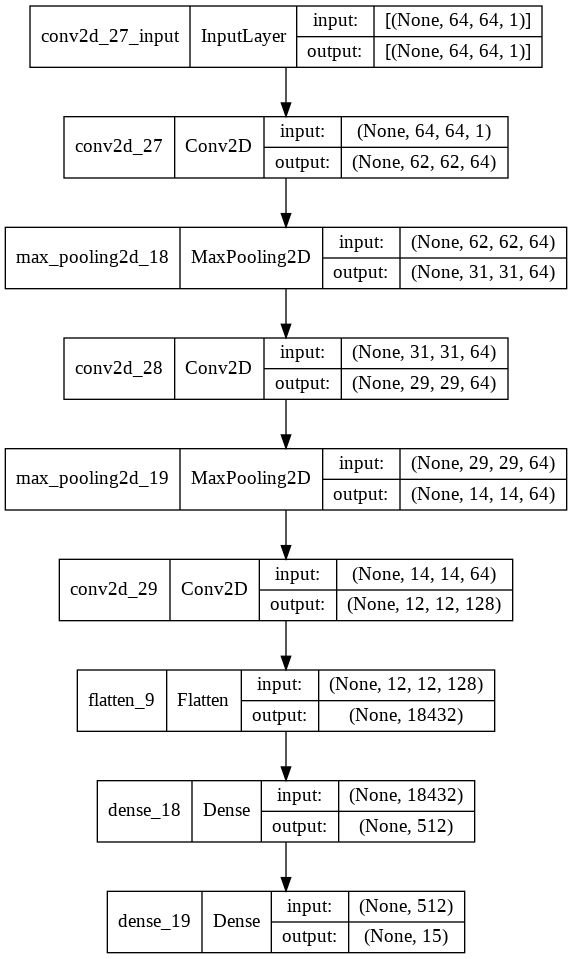

In [ ]:
visualise_model(construct_tuned_model((3, 3), 'relu', optimizers.RMSprop(learning_rate=0.00025)))

In [ ]:
history = train_model(construct_tuned_model((3, 3), 'relu', optimizers.RMSprop(learning_rate=0.00025)), 30)

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 1.3312 - accuracy: 0.5863
Epoch 00001: val_loss improved from inf to 0.64554, saving model to optimum-model.h5
150/150 [==============================] - 99s 655ms/step - loss: 1.3312 - accuracy: 0.5863 - val_loss: 0.6455 - val_accuracy: 0.8046
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.4720 - accuracy: 0.8476
Epoch 00002: val_loss improved from 0.64554 to 0.45613, saving model to optimum-model.h5
150/150 [==============================] - 98s 652ms/step - loss: 0.4720 - accuracy: 0.8476 - val_loss: 0.4561 - val_accuracy: 0.8596
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.2712 - accuracy: 0.9091
Epoch 00003: val_loss improved from 0.45613 to 0.37743, saving model to optimum-model.h5
150/150 [==============================] - 98s 652ms/step - loss: 0.2712 - accuracy: 0.9091 - val_loss: 0.3774 - val_accuracy: 0.8742
Epoch 4/30
150/150 [===========================

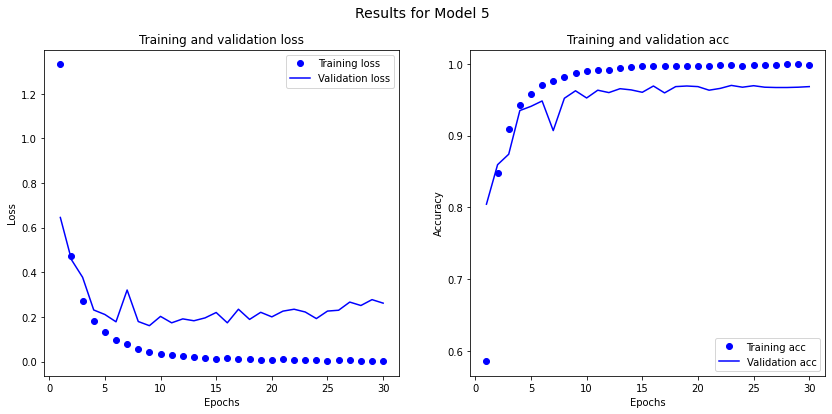

In [ ]:
plot_model_history(history, name="Model 5")

#### **Summary of Model 5**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |
| 3 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0001 | 0.2020 | 0.9546 | Although the accuracy has slightly decreased, the loss has stabilised. However, there are still signs of overfitting |
| 4 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0005 | 0.1130 | 0.9758 | Increasing the learning rate has sacrificed the stability of the loss, but the validation loss decreased and validation accuracy increased |
| 5 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.00025 | 0.1606 | 0.9625 | The model has slightly stabilised, however overfitting occurred at the 7th epoch |

The outputs from model 5 shows that the model has become somewhat stable. However, the model is still showing signs of overfitting and has caused the validation loss to drastically increase from 0.1130 to 0.1606, as well as the validation accuracy to decrease from 0.9758 to 0.9625. The optimal epoch also dropped from 10 to 9 which means the model hasn't really improved.

Due to the unsatisfactory results, I will be reverting back to the learning rate of 0.0005. Instead of tuning the learning rate, I will be changing the optimiser function to `adam`. This should hopefully give me an idea on which optimiser function works best for my model.

### **Model 6 - Change the optimiser function to `adam`**

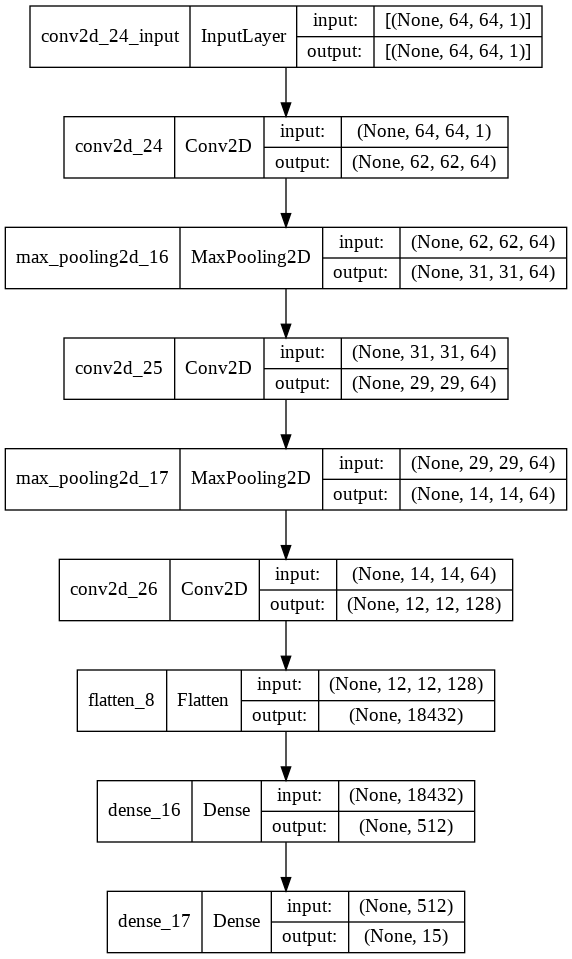

In [ ]:
visualise_model(construct_tuned_model((3, 3), 'relu', optimizers.Adam(learning_rate=0.0005)))

In [ ]:
history = train_model(construct_tuned_model((3, 3), 'relu', optimizers.Adam(learning_rate=0.0005)), 30)

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 1.0276 - accuracy: 0.6748
Epoch 00001: val_loss improved from inf to 0.35404, saving model to optimum-model.h5
150/150 [==============================] - 96s 638ms/step - loss: 1.0276 - accuracy: 0.6748 - val_loss: 0.3540 - val_accuracy: 0.8929
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.2360 - accuracy: 0.9246
Epoch 00002: val_loss improved from 0.35404 to 0.23008, saving model to optimum-model.h5
150/150 [==============================] - 96s 637ms/step - loss: 0.2360 - accuracy: 0.9246 - val_loss: 0.2301 - val_accuracy: 0.9287
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9634
Epoch 00003: val_loss improved from 0.23008 to 0.16333, saving model to optimum-model.h5
150/150 [==============================] - 96s 638ms/step - loss: 0.1213 - accuracy: 0.9634 - val_loss: 0.1633 - val_accuracy: 0.9529
Epoch 4/30
150/150 [===========================

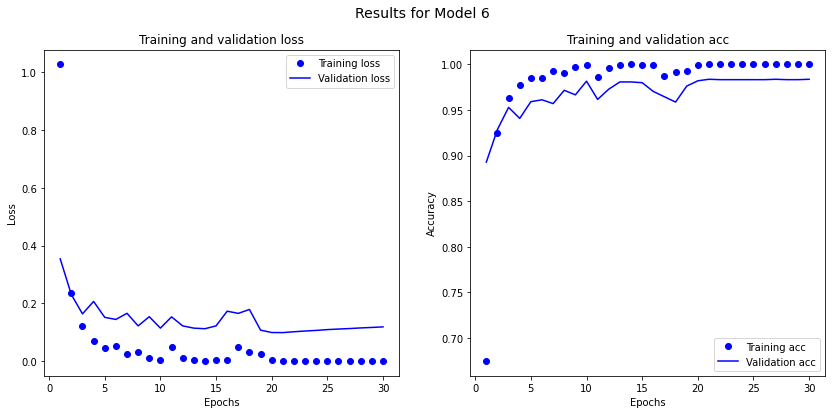

In [ ]:
plot_model_history(history, name="Model 6")

#### **Summary of Model 6**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |
| 3 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0001 | 0.2020 | 0.9546 | Although the accuracy has slightly decreased, the loss has stabilised. However, there are still signs of overfitting |
| 4 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0005 | 0.1130 | 0.9758 | Increasing the learning rate has sacrificed the stability of the loss, but the validation loss decreased and validation accuracy increased |
| 5 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.00025 | 0.1606 | 0.9625 | The model has slightly stabilised, however overfitting occurred at the 7th epoch |
| 6 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | adam | 0.0005 | 0.0984 | 0.9837 | It is clear that the Adam optimiser function performs better than the RMSProp optimiser function as an optimal validation loss/accuracy has been achieved at epoch 21 |


The outputs from model 6 has shown that the `adam` optimiser is the most suitable function for this model. The validation loss has improved from 0.1130 to 0.0984, and the validation accuracy has improved from 0.9758 to 0.9837 when compared with model 4. 

On the other hand, the graph plots illustrate that overfitting still occurs due to the minor fluctuations in the validation loss and accuracy. However, once the optimal epoch has been reached, they start to stablise and become smooth.

Overall, the results for changing the optimiser function was a success as it not only performed well with the model but also produced better metrics compared to all the other models. Now that the learning rate has been tuned with a suitable optimiser, I will now be experimenting with the `tanh` activation function to observe how well the model learns with the given training set compared to `relu`. Much research has shown that a network learns much faster with a `tanh` activation function than with `relu`. The next model iteration will indicate which activation function is most reliable.

### **Model 7 - Change the activation function to `tanh`**

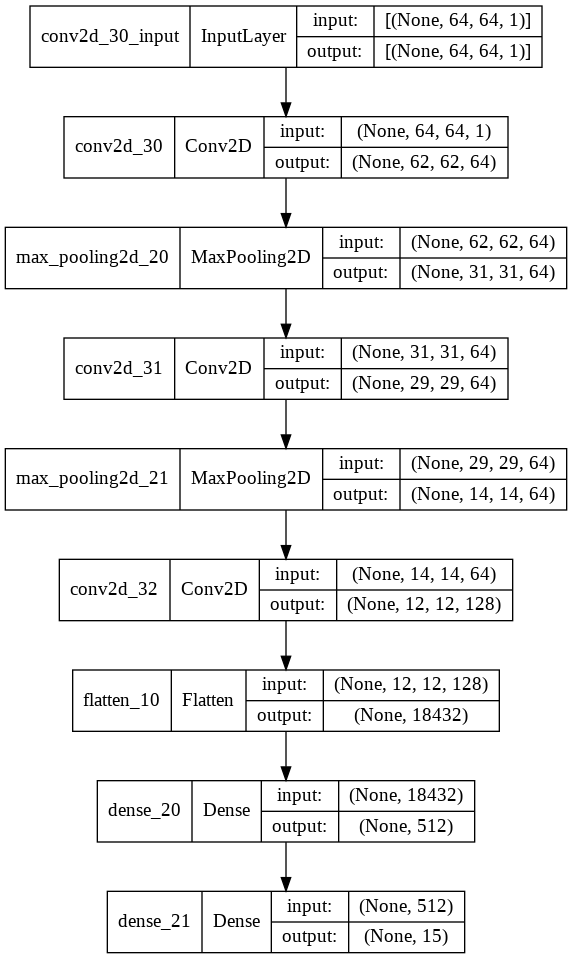

In [ ]:
visualise_model(construct_tuned_model((3, 3), 'tanh', optimizers.Adam(learning_rate=0.0005)))

In [ ]:
history = train_model(construct_tuned_model((3, 3), 'tanh', optimizers.Adam(learning_rate=0.0005)), 30)

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 0.9521 - accuracy: 0.7010
Epoch 00001: val_loss improved from inf to 0.38100, saving model to optimum-model.h5
150/150 [==============================] - 97s 643ms/step - loss: 0.9521 - accuracy: 0.7010 - val_loss: 0.3810 - val_accuracy: 0.8846
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.2667 - accuracy: 0.9130
Epoch 00002: val_loss improved from 0.38100 to 0.28886, saving model to optimum-model.h5
150/150 [==============================] - 96s 641ms/step - loss: 0.2667 - accuracy: 0.9130 - val_loss: 0.2889 - val_accuracy: 0.9021
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.1584 - accuracy: 0.9472
Epoch 00003: val_loss improved from 0.28886 to 0.20821, saving model to optimum-model.h5
150/150 [==============================] - 96s 642ms/step - loss: 0.1584 - accuracy: 0.9472 - val_loss: 0.2082 - val_accuracy: 0.9308
Epoch 4/30
150/150 [===========================

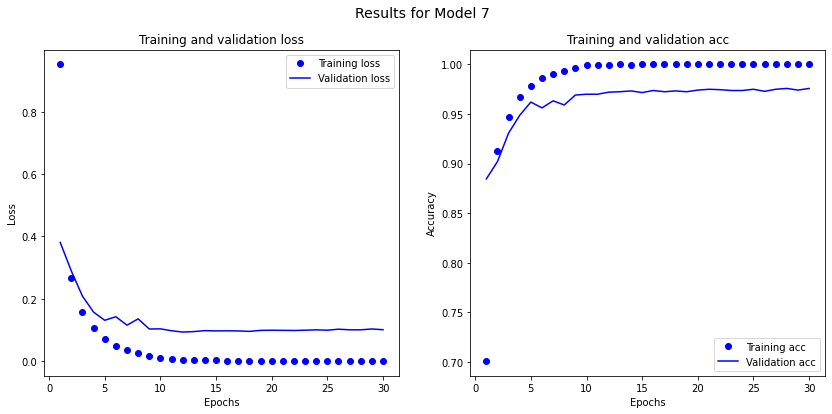

In [ ]:
plot_model_history(history, name="Model 7")

#### **Summary of Model 7**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |
| 3 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0001 | 0.2020 | 0.9546 | Although the accuracy has slightly decreased, the loss has stabilised. However, there are still signs of overfitting |
| 4 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0005 | 0.1130 | 0.9758 | Increasing the learning rate has sacrificed the stability of the loss, but the validation loss decreased and validation accuracy increased |
| 5 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.00025 | 0.1606 | 0.9625 | The model has slightly stabilised, however overfitting occurred at the 7th epoch |
| 6 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | adam | 0.0005 | 0.0984 | 0.9837 | It is clear that the Adam optimiser function performs better than the RMSProp optimiser function as an optimal validation loss/accuracy has been achieved at epoch 21 |
| 7 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0931 | 0.9721 | Validation loss has consistently decreased and reached its optimal at epoch 12. The model now looks much more stabilised with less noise |


The outputs from model 7 has shown that the `tanh` is a more suitable activation function for this model. This is evident from the graph plots illustrating stabilised metrics and less noise. Compared to the previous model, the validation loss managed to decrease from 0.0987 to 0.0931. Although the validation accuracy slightly decreased to 0.9721, this model still performs better than the previous one as it has a better validation loss. Validation loss is more important than accuracy as it indicates how well the model fits unseen data and if errors are occurring during training. 

Overall, the results were a success and we can conclude that `tanh` enables the model to learn much faster with the given training set compared to `relu`, and produces less noise. I will now be experimenting with the kernel sizes for each 2D convolutional layer in the model to see whether it can further improves the performance of the model.

### **Model 8 - Increase the size of the convolutional kernel to (5, 5)**

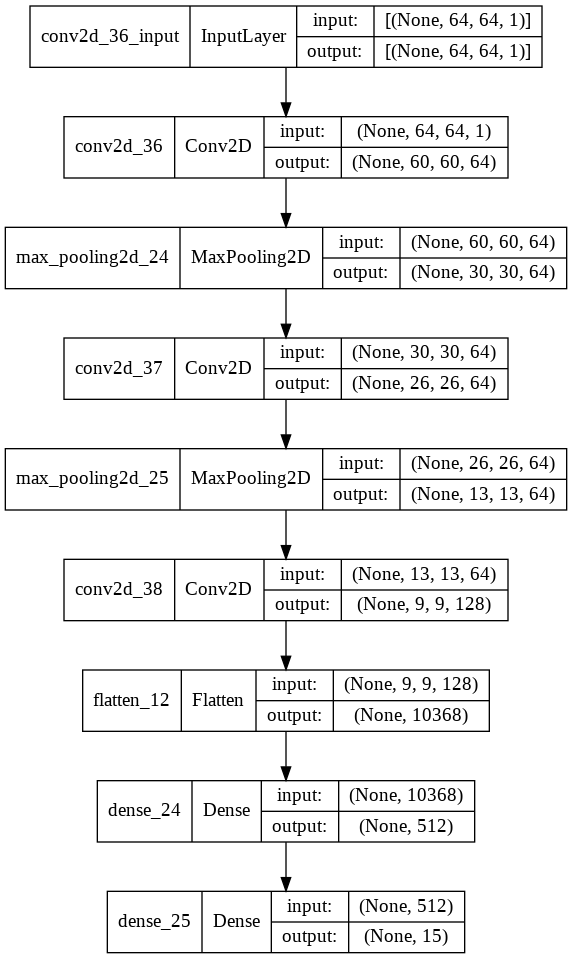

In [ ]:
visualise_model(construct_tuned_model((5, 5), 'tanh', optimizers.Adam(learning_rate=0.0005)))

In [ ]:
history = train_model(construct_tuned_model((5, 5), 'tanh', optimizers.Adam(learning_rate=0.0005)), 30)

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 0.9105 - accuracy: 0.7097
Epoch 00001: val_loss improved from inf to 0.44062, saving model to optimum-model.h5
150/150 [==============================] - 150s 997ms/step - loss: 0.9105 - accuracy: 0.7097 - val_loss: 0.4406 - val_accuracy: 0.8546
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.2349 - accuracy: 0.9244
Epoch 00002: val_loss improved from 0.44062 to 0.19618, saving model to optimum-model.h5
150/150 [==============================] - 149s 996ms/step - loss: 0.2349 - accuracy: 0.9244 - val_loss: 0.1962 - val_accuracy: 0.9367
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.9588
Epoch 00003: val_loss improved from 0.19618 to 0.15891, saving model to optimum-model.h5
150/150 [==============================] - 149s 995ms/step - loss: 0.1290 - accuracy: 0.9588 - val_loss: 0.1589 - val_accuracy: 0.9533
Epoch 4/30
150/150 [========================

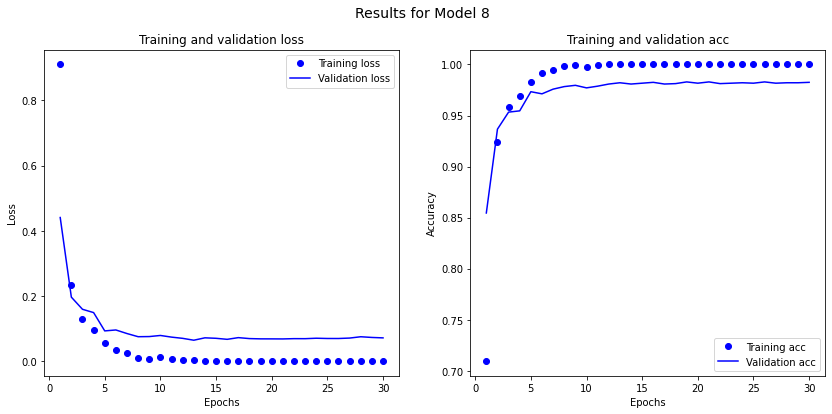

In [ ]:
plot_model_history(history, name="Model 8")

#### **Summary of Model 8**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |
| 3 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0001 | 0.2020 | 0.9546 | Although the accuracy has slightly decreased, the loss has stabilised. However, there are still signs of overfitting |
| 4 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0005 | 0.1130 | 0.9758 | Increasing the learning rate has sacrificed the stability of the loss, but the validation loss decreased and validation accuracy increased |
| 5 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.00025 | 0.1606 | 0.9625 | The model has slightly stabilised, however overfitting occurred at the 7th epoch |
| 6 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | adam | 0.0005 | 0.0984 | 0.9837 | It is clear that the Adam optimiser function performs better than the RMSProp optimiser function as an optimal validation loss/accuracy has been achieved at epoch 21 |
| 7 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0931 | 0.9721 | Validation loss has consistently decreased and reached its optimal at epoch 12. The model now looks much more stabilised with less noise |
| 8 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0639 | 0.9821 | Lowest validation loss was achieved at epoch 13. The performance of the model has improved after increasing the convolutional kernel size to (5, 5) |


The outputs from model 8 has shown that the performance of the model has improved in both validation loss and validation accuracy after increasing the convolutional kernel size to (5, 5). We can clearly observe that overfitting is being minimised because of this, as illustrated on the graph plots. The validation loss was consistently decreasing throughout the training process with an optimal loss of 0.0639 compared to 0.0931 from the previous model. The validation accuracy gradually increased throughout the training process with optimal accuracy of 0.9821 compared to 0.9721 from the previous model. Although there were minor fluctuations between epoch 7 and 10, the model still managed to stabilise. 

Overall, the results were successful and we can conclude that a convolutional kernel size of (5, 5) performs better on this model than (3, 3). I will now be implementing further regularisation techniques such as adding dropout layers, to further minimise overfitting.

### **Model 9 - Add a dropout layer of 0.1**

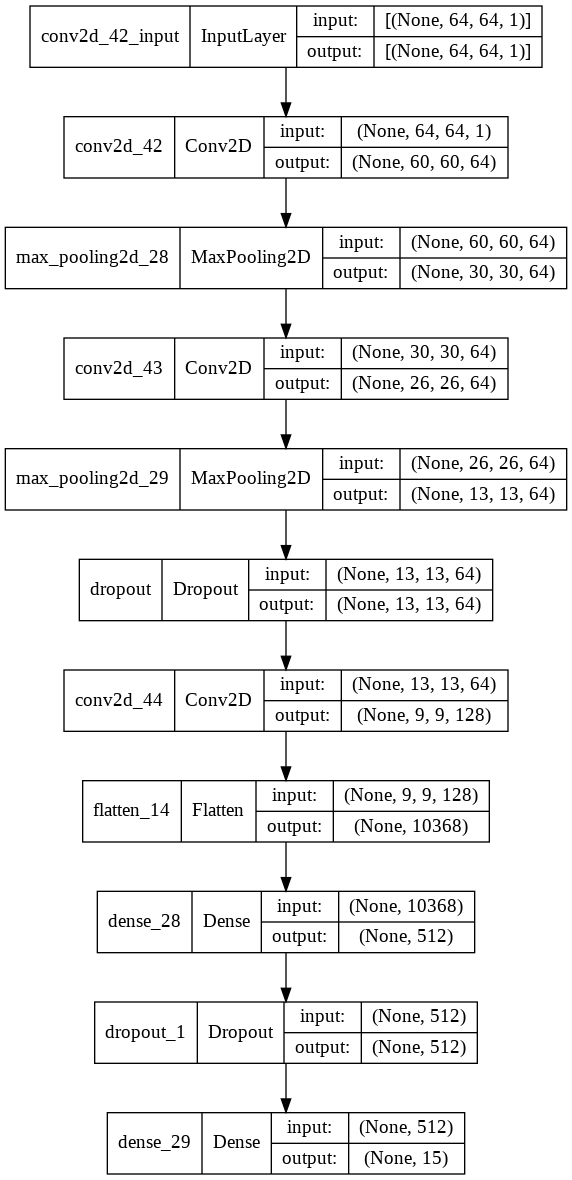

In [ ]:
visualise_model(construct_regularised_model([64, 64, 128, 512], 0.1))

In [ ]:
history = train_model(construct_regularised_model([64, 64, 128, 512], 0.1), 30)

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 1.1305 - accuracy: 0.6379
Epoch 00001: val_loss improved from inf to 0.46104, saving model to optimum-model.h5
150/150 [==============================] - 152s 1s/step - loss: 1.1305 - accuracy: 0.6379 - val_loss: 0.4610 - val_accuracy: 0.8567
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.3143 - accuracy: 0.8990
Epoch 00002: val_loss improved from 0.46104 to 0.23702, saving model to optimum-model.h5
150/150 [==============================] - 150s 998ms/step - loss: 0.3143 - accuracy: 0.8990 - val_loss: 0.2370 - val_accuracy: 0.9283
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.1959 - accuracy: 0.9364
Epoch 00003: val_loss did not improve from 0.23702
150/150 [==============================] - 150s 1s/step - loss: 0.1959 - accuracy: 0.9364 - val_loss: 0.2488 - val_accuracy: 0.9196
Epoch 4/30
150/150 [==============================] - ETA: 0s - loss: 0.1444 - accuracy:

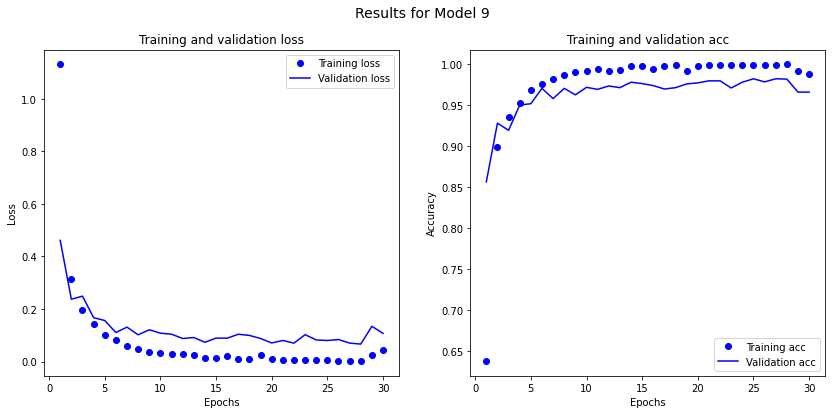

In [ ]:
plot_model_history(history, name="Model 9")

#### **Summary of Model 9**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |
| 3 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0001 | 0.2020 | 0.9546 | Although the accuracy has slightly decreased, the loss has stabilised. However, there are still signs of overfitting |
| 4 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0005 | 0.1130 | 0.9758 | Increasing the learning rate has sacrificed the stability of the loss, but the validation loss decreased and validation accuracy increased |
| 5 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.00025 | 0.1606 | 0.9625 | The model has slightly stabilised, however overfitting occurred at the 7th epoch |
| 6 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | adam | 0.0005 | 0.0984 | 0.9837 | It is clear that the Adam optimiser function performs better than the RMSProp optimiser function as an optimal validation loss/accuracy has been achieved at epoch 21 |
| 7 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0931 | 0.9721 | Validation loss has consistently decreased and reached its optimal at epoch 12. The model now looks much more stabilised with less noise |
| 8 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0639 | 0.9821 | Lowest validation loss was achieved at epoch 13. The performance of the model has improved after increasing the convolutional kernel size to (5, 5) |
| 9 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0663 | 0.9821 | Lowest validation loss was achieved at epoch 28. Overfitting has not improved since the validation loss has slightly increased and started to fluctuate |


The outputs from model 9 has shown that overfitting has not improved any further which means that adding a dropout value of 0.1 has decreased the performance of the model. Whilst the optimal validation accuracy has managed to remain the same, the validation loss has slightly increased from 0.0639 to 0.0663. The graph plots illustrate that overfitting has become worse as there is fluctuation and noise.

I have now decided to tweak the dropout value to 0.5 for the next model iteration, since much research has shown that an ideal dropout value should be go up to 0.5 (depending on the complexity of the model) to minimise overfitting.

### **Model 10 - Change the dropout layer value to 0.5**

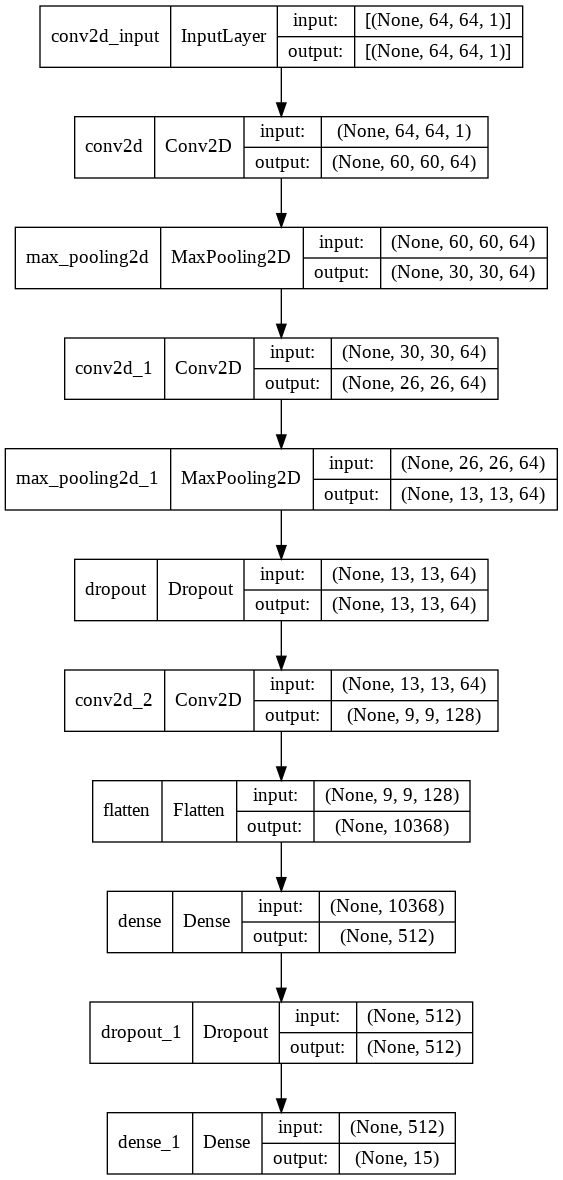

In [ ]:
visualise_model(construct_regularised_model([64, 64, 128, 512], 0.5))

In [ ]:
history = train_model(construct_regularised_model([64, 64, 128, 512], 0.5), 30)

Epoch 1/30
150/150 [==============================] - ETA: 0s - loss: 1.4182 - accuracy: 0.5501
Epoch 00001: val_loss improved from inf to 0.58026, saving model to optimum-model.h5
150/150 [==============================] - 178s 1s/step - loss: 1.4182 - accuracy: 0.5501 - val_loss: 0.5803 - val_accuracy: 0.8112
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.4946 - accuracy: 0.8357
Epoch 00002: val_loss improved from 0.58026 to 0.35851, saving model to optimum-model.h5
150/150 [==============================] - 176s 1s/step - loss: 0.4946 - accuracy: 0.8357 - val_loss: 0.3585 - val_accuracy: 0.8875
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.3459 - accuracy: 0.8816
Epoch 00003: val_loss improved from 0.35851 to 0.22207, saving model to optimum-model.h5
150/150 [==============================] - 179s 1s/step - loss: 0.3459 - accuracy: 0.8816 - val_loss: 0.2221 - val_accuracy: 0.9354
Epoch 4/30
150/150 [==============================] -

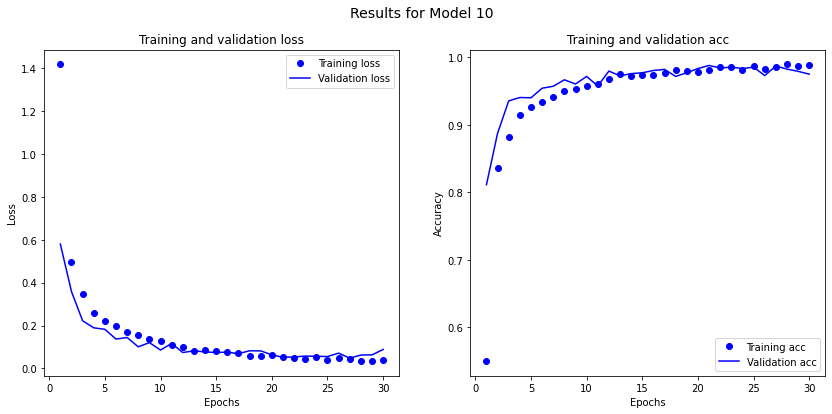

In [ ]:
plot_model_history(history, name="Model 10")

#### **Summary of Model 10**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |
| 3 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0001 | 0.2020 | 0.9546 | Although the accuracy has slightly decreased, the loss has stabilised. However, there are still signs of overfitting |
| 4 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0005 | 0.1130 | 0.9758 | Increasing the learning rate has sacrificed the stability of the loss, but the validation loss decreased and validation accuracy increased |
| 5 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.00025 | 0.1606 | 0.9625 | The model has slightly stabilised, however overfitting occurred at the 7th epoch |
| 6 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | adam | 0.0005 | 0.0984 | 0.9837 | It is clear that the Adam optimiser function performs better than the RMSProp optimiser function as an optimal validation loss/accuracy has been achieved at epoch 21 |
| 7 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0931 | 0.9721 | Validation loss has consistently decreased and reached its optimal at epoch 12. The model now looks much more stabilised with less noise |
| 8 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0639 | 0.9821 | Lowest validation loss was achieved at epoch 13. The performance of the model has improved after increasing the convolutional kernel size to (5, 5) |
| 9 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0663 | 0.9821 | Lowest validation loss was achieved at epoch 28. Overfitting has not improved since the validation loss has slightly increased and started to fluctuate |
| 10 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0474 | 0.9871 | Lowest validation loss was achieved at epoch 27. Overfitting has clearly been improved as the validation loss has decreased with a more smoothed line |


The outputs from model 10 shows that tweaking the dropout value has improved the overfitting of the model as illustrated on the graph plots. This proved my speculation of understanding the ideal dropout value to be correct. Compared to the previous model, the validation loss has improved by decreasing from 0.0663 to 0.0474 and the validation accuracy has improved by slightly increasing from 0.9821 to 0.9871. When the results are compared with all other models, we can observe that this is the best model. 

Overall, the results were successful. I have now decided to further tweak the dropout value to 0.4 for the next model iteration to observe whether the validation loss and accuracy can further be improved.

### **Model 11 - Change the dropout layer value to 0.4**

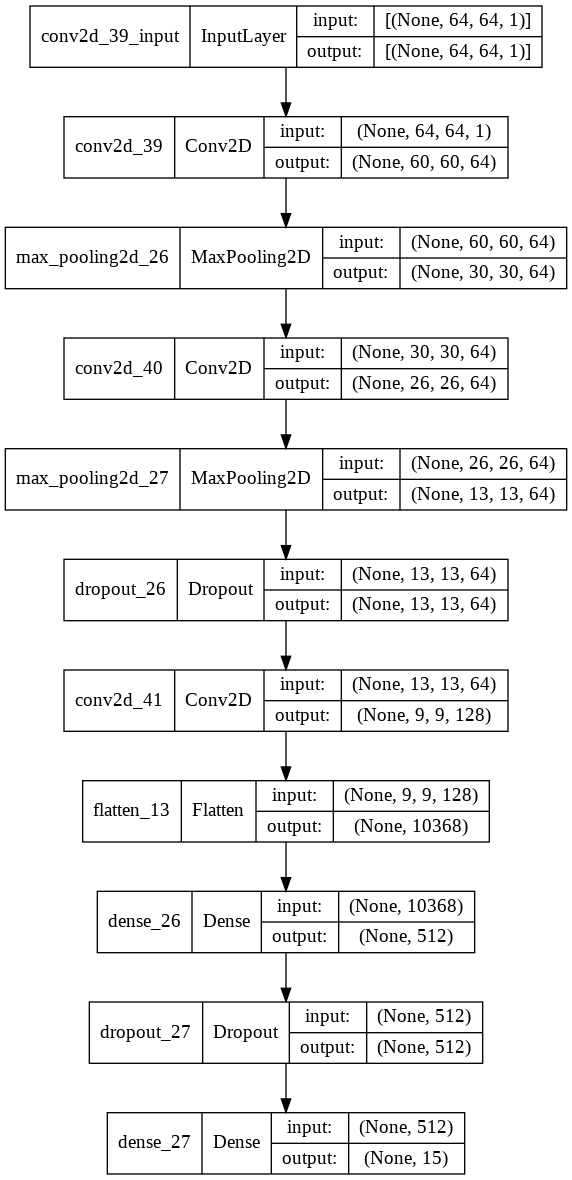

In [ ]:
visualise_model(construct_regularised_model([64, 64, 128, 512], 0.4))

In [ ]:
history = train_model(construct_regularised_model([64, 64, 128, 512], 0.4), 30)

Epoch 1/30
147/150 [============================>.] - ETA: 0s - loss: 1.0154 - accuracy: 0.6706
Epoch 00001: val_loss improved from inf to 0.34173, saving model to optimum-model.h5
150/150 [==============================] - 4s 19ms/step - loss: 1.0046 - accuracy: 0.6735 - val_loss: 0.3417 - val_accuracy: 0.8896
Epoch 2/30
149/150 [============================>.] - ETA: 0s - loss: 0.3461 - accuracy: 0.8841
Epoch 00002: val_loss improved from 0.34173 to 0.20221, saving model to optimum-model.h5
150/150 [==============================] - 3s 17ms/step - loss: 0.3463 - accuracy: 0.8841 - val_loss: 0.2022 - val_accuracy: 0.9254
Epoch 3/30
148/150 [============================>.] - ETA: 0s - loss: 0.2177 - accuracy: 0.9272
Epoch 00003: val_loss did not improve from 0.20221
150/150 [==============================] - 3s 17ms/step - loss: 0.2185 - accuracy: 0.9269 - val_loss: 0.2279 - val_accuracy: 0.9196
Epoch 4/30
149/150 [============================>.] - ETA: 0s - loss: 0.1716 - accuracy: 0.

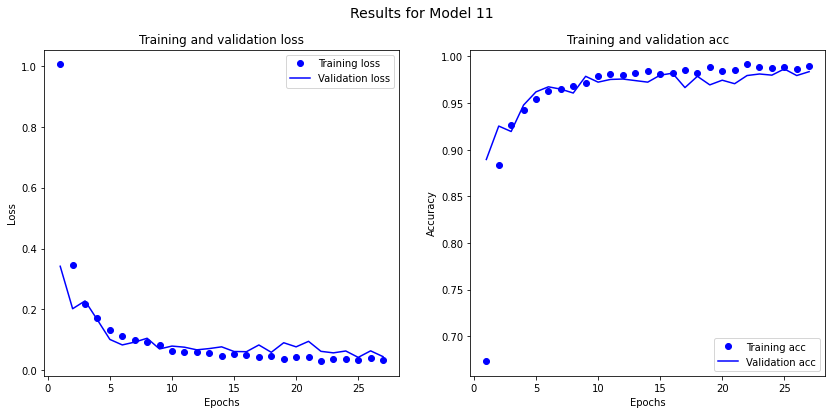

In [ ]:
plot_model_history(history, name="Model 11")

#### **Summary of Model 11**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |
| 3 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0001 | 0.2020 | 0.9546 | Although the accuracy has slightly decreased, the loss has stabilised. However, there are still signs of overfitting |
| 4 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0005 | 0.1130 | 0.9758 | Increasing the learning rate has sacrificed the stability of the loss, but the validation loss decreased and validation accuracy increased |
| 5 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.00025 | 0.1606 | 0.9625 | The model has slightly stabilised, however overfitting occurred at the 7th epoch |
| 6 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | adam | 0.0005 | 0.0984 | 0.9837 | It is clear that the Adam optimiser function performs better than the RMSProp optimiser function as an optimal validation loss/accuracy has been achieved at epoch 21 |
| 7 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0931 | 0.9721 | Validation loss has consistently decreased and reached its optimal at epoch 12. The model now looks much more stabilised with less noise |
| 8 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0639 | 0.9821 | Lowest validation loss was achieved at epoch 13. The performance of the model has improved after increasing the convolutional kernel size to (5, 5) |
| 9 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0663 | 0.9821 | Lowest validation loss was achieved at epoch 28. Overfitting has not improved since the validation loss has slightly increased and started to fluctuate |
| 10 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0474 | 0.9871 | Lowest validation loss was achieved at epoch 27. Overfitting has clearly been improved as the validation loss has decreased with a more smoothed line |
| 11 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0424 | 0.9867 | Lowest validation loss was achieved at epoch 25. Although an optimal validation loss was achieved, overfitting still needed to be improved as there were minor fluctuations with the metrics creating minor noise |


The outputs from model 11 shows that further tweaking the dropout value to 0.4 has allowed the model to achieve an optimal validation loss of 0.0424, compared to the previous model which has 0.0474. However, the graph plot illustrations still produce some minor noise which indicates that overfitting hasn't entirely been improved yet, since there are minor fluctuations with both the validation loss and validation accuracy. This could be due the capacity of the network e.g. the number of filters in the hidden layers.

Overall, the results have shown success as an optimal validation loss has yet again been achieved regardless of the fact that the validation accuracy slightly decreased. I will now be experimenting with the filters for both the 2D convolutional layers and the dense layers, to observe whether the minor noise could be attributed to the capacity of the network and whether decreasing the filters could improve the performance of the model.

### **Model 12 - Decrease the filters for the conv2D layers to (32,32,64) and first dense layer to 256**

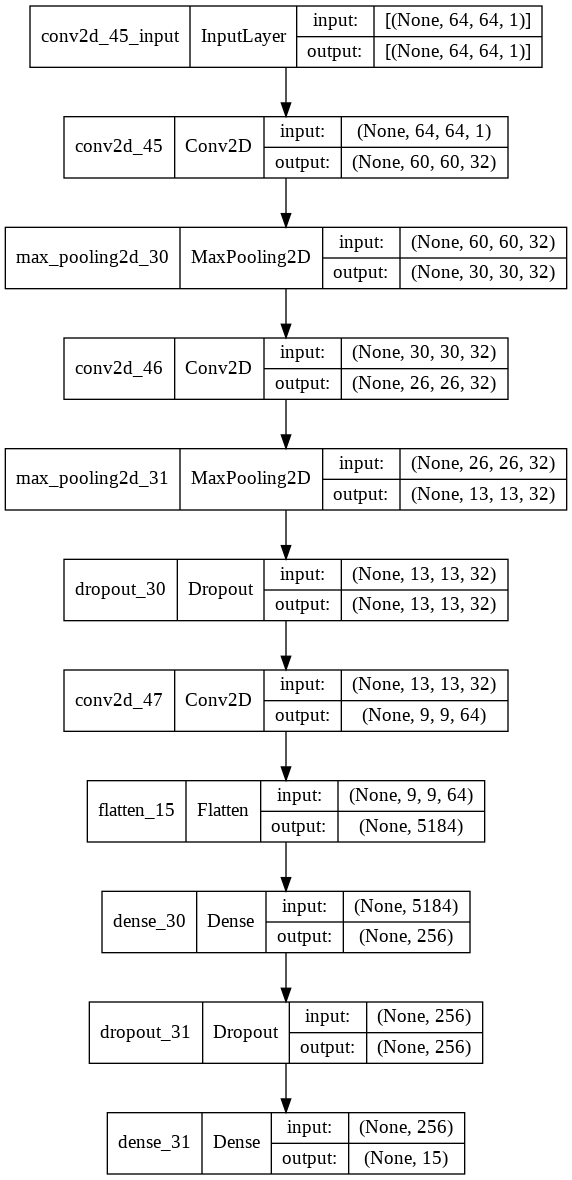

In [ ]:
visualise_model(construct_regularised_model([32, 32, 64, 256], 0.4))

In [ ]:
history = train_model(construct_regularised_model([32, 32, 64, 256], 0.4), 30)

Epoch 1/30
148/150 [============================>.] - ETA: 0s - loss: 1.4336 - accuracy: 0.5401
Epoch 00001: val_loss improved from inf to 0.61537, saving model to optimum-model.h5
150/150 [==============================] - 3s 15ms/step - loss: 1.4232 - accuracy: 0.5440 - val_loss: 0.6154 - val_accuracy: 0.8096
Epoch 2/30
150/150 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.8104
Epoch 00002: val_loss improved from 0.61537 to 0.35221, saving model to optimum-model.h5
150/150 [==============================] - 1s 10ms/step - loss: 0.5520 - accuracy: 0.8104 - val_loss: 0.3522 - val_accuracy: 0.8829
Epoch 3/30
145/150 [============================>.] - ETA: 0s - loss: 0.3633 - accuracy: 0.8756
Epoch 00003: val_loss improved from 0.35221 to 0.23696, saving model to optimum-model.h5
150/150 [==============================] - 1s 10ms/step - loss: 0.3615 - accuracy: 0.8766 - val_loss: 0.2370 - val_accuracy: 0.9242
Epoch 4/30
149/150 [============================>.] -

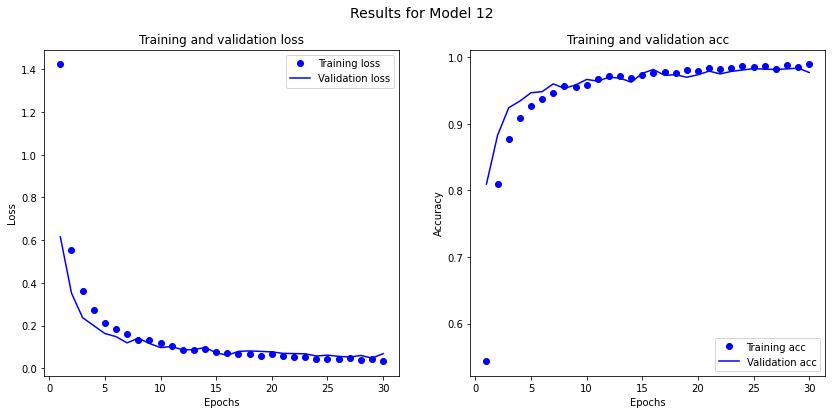

In [ ]:
plot_model_history(history, name="Model 12")

#### **Summary of Model 12**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |
| 3 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0001 | 0.2020 | 0.9546 | Although the accuracy has slightly decreased, the loss has stabilised. However, there are still signs of overfitting |
| 4 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0005 | 0.1130 | 0.9758 | Increasing the learning rate has sacrificed the stability of the loss, but the validation loss decreased and validation accuracy increased |
| 5 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.00025 | 0.1606 | 0.9625 | The model has slightly stabilised, however overfitting occurred at the 7th epoch |
| 6 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | adam | 0.0005 | 0.0984 | 0.9837 | It is clear that the Adam optimiser function performs better than the RMSProp optimiser function as an optimal validation loss/accuracy has been achieved at epoch 21 |
| 7 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0931 | 0.9721 | Validation loss has consistently decreased and reached its optimal at epoch 12. The model now looks much more stabilised with less noise |
| 8 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0639 | 0.9821 | Lowest validation loss was achieved at epoch 13. The performance of the model has improved after increasing the convolutional kernel size to (5, 5) |
| 9 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0663 | 0.9821 | Lowest validation loss was achieved at epoch 28. Overfitting has not improved since the validation loss has slightly increased and started to fluctuate |
| 10 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0474 | 0.9871 | Lowest validation loss was achieved at epoch 27. Overfitting has clearly been improved as the validation loss has decreased with a more smoothed line |
| 11 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0424 | 0.9867 | Lowest validation loss was achieved at epoch 25. Although an optimal validation loss was achieved, overfitting still needed to be improved as there were minor fluctuations with the metrics creating minor noise |
| 12 | 32, 32, 64, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0477 | 0.9837 | Lowest validation loss was achieved at epoch 29. Overfitting has improved after decreasing the network capacity. However, the validation loss could be better |

The outputs from model 12 shows that decreasing the network capacity by reducing the number of filters in both the 2D convolutional and dense layers, has proved my speculation to be correct. The noise being produced from the previous model's graph plot illustrations was attributed to the capacity of the network. Thus, by reducing its capacity for this iteration, the model has become more stabilised.

I will now be further tweaking the model by further reducing the filters again. This will hopefully be an indicator to both the performance of the model and the improvement in overfitting.

### **Model 13 - Decrease the filters for the conv2D layers to (16,16,32) and first dense layer to 64**

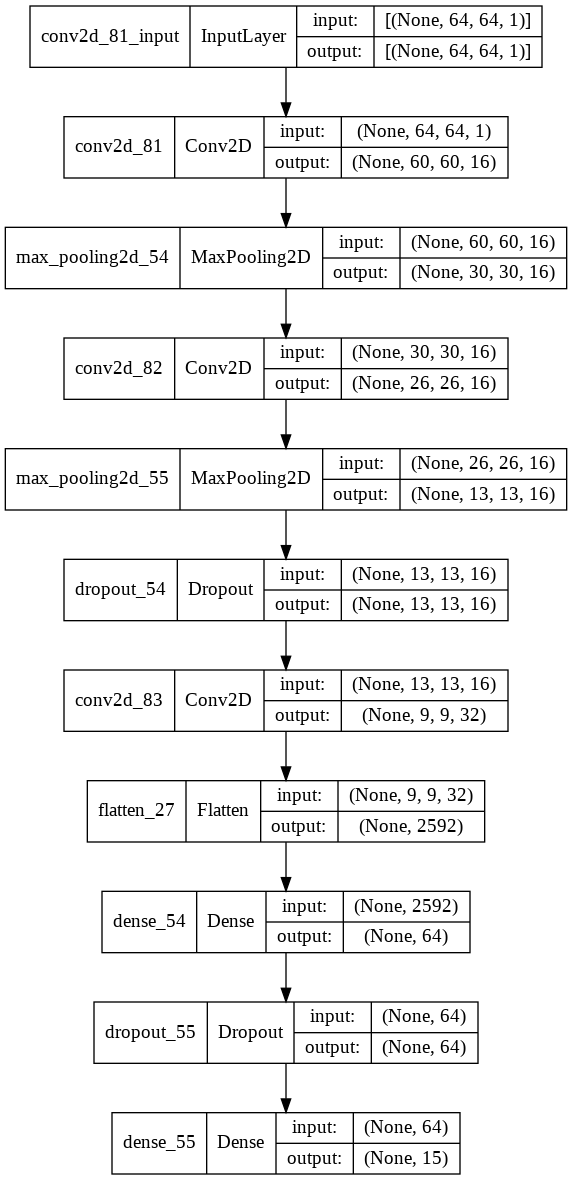

In [ ]:
visualise_model(construct_regularised_model([16, 16, 32, 64], 0.4))

In [ ]:
history = train_model(construct_regularised_model([16, 16, 32, 64], 0.4), 30)

Epoch 1/30
144/150 [===========================>..] - ETA: 0s - loss: 2.0306 - accuracy: 0.3602
Epoch 00001: val_loss improved from inf to 1.28021, saving model to optimum-model.h5
150/150 [==============================] - 2s 9ms/step - loss: 2.0091 - accuracy: 0.3671 - val_loss: 1.2802 - val_accuracy: 0.6208
Epoch 2/30
145/150 [============================>.] - ETA: 0s - loss: 1.1245 - accuracy: 0.6375
Epoch 00002: val_loss improved from 1.28021 to 0.75998, saving model to optimum-model.h5
150/150 [==============================] - 1s 7ms/step - loss: 1.1213 - accuracy: 0.6382 - val_loss: 0.7600 - val_accuracy: 0.7696
Epoch 3/30
146/150 [============================>.] - ETA: 0s - loss: 0.7793 - accuracy: 0.7501
Epoch 00003: val_loss improved from 0.75998 to 0.53981, saving model to optimum-model.h5
150/150 [==============================] - 1s 7ms/step - loss: 0.7772 - accuracy: 0.7507 - val_loss: 0.5398 - val_accuracy: 0.8354
Epoch 4/30
148/150 [============================>.] - ET

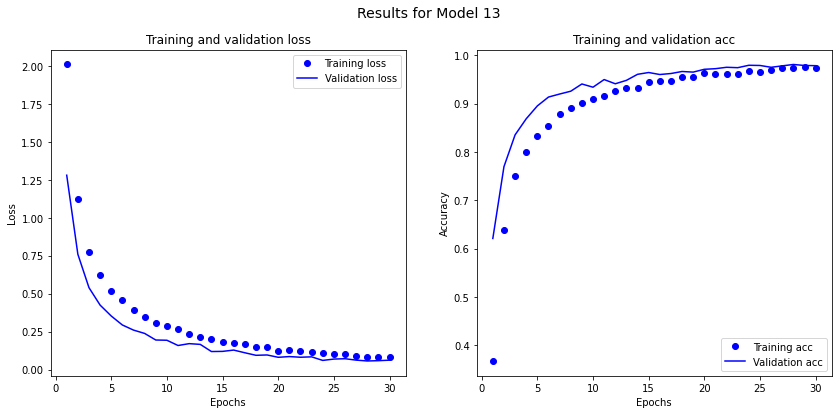

In [ ]:
plot_model_history(history, name="Model 13")

#### **Summary of Model 13**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |
| 3 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0001 | 0.2020 | 0.9546 | Although the accuracy has slightly decreased, the loss has stabilised. However, there are still signs of overfitting |
| 4 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0005 | 0.1130 | 0.9758 | Increasing the learning rate has sacrificed the stability of the loss, but the validation loss decreased and validation accuracy increased |
| 5 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.00025 | 0.1606 | 0.9625 | The model has slightly stabilised, however overfitting occurred at the 7th epoch |
| 6 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | adam | 0.0005 | 0.0984 | 0.9837 | It is clear that the Adam optimiser function performs better than the RMSProp optimiser function as an optimal validation loss/accuracy has been achieved at epoch 21 |
| 7 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0931 | 0.9721 | Validation loss has consistently decreased and reached its optimal at epoch 12. The model now looks much more stabilised with less noise |
| 8 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0639 | 0.9821 | Lowest validation loss was achieved at epoch 13. The performance of the model has improved after increasing the convolutional kernel size to (5, 5) |
| 9 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0663 | 0.9821 | Lowest validation loss was achieved at epoch 28. Overfitting has not improved since the validation loss has slightly increased and started to fluctuate |
| 10 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0474 | 0.9871 | Lowest validation loss was achieved at epoch 27. Overfitting has clearly been improved as the validation loss has decreased with a more smoothed line |
| 11 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0424 | 0.9867 | Lowest validation loss was achieved at epoch 25. Although an optimal validation loss was achieved, overfitting still needed to be improved as there were minor fluctuations with the metrics creating minor noise |
| 12 | 32, 32, 64, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0477 | 0.9837 | Lowest validation loss was achieved at epoch 29. Overfitting has improved after decreasing the network capacity. However, the validation loss could be better |
| 13 | 16, 16, 32, 64, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0572 | 0.9812 | Lowest validation loss was achieved at epoch 28. Overfitting has started to decline since the training loss is higher than the validation loss as shown on the illustrated graph plots |

The outputs from model 13 shows that further decreasing the network capacity by halving the number of filters in the 2D convolutional layers and drastically decreasing the first dense layer to 64, has led to a decline in the performance of the model. As illustrated on the graph plots, the training loss is higher than the validation loss and the the training accuracy is lower than the validation accuracy. This is a clear sign of overfitting which means that the capacity of the network would need to be further downsized or adjusted by changing the filters.

Overall, the model has not been a successful iteration due the failure in mitigating overfitting. For the next model iteration, I will be running more experiments on the 2D convolutional layer and dense layer to observe whether adjusting them can improve the overfitting of the model.

### **Model 14 - Increase the filter for the second conv2D layer to 32 and the first dense layer to 256**

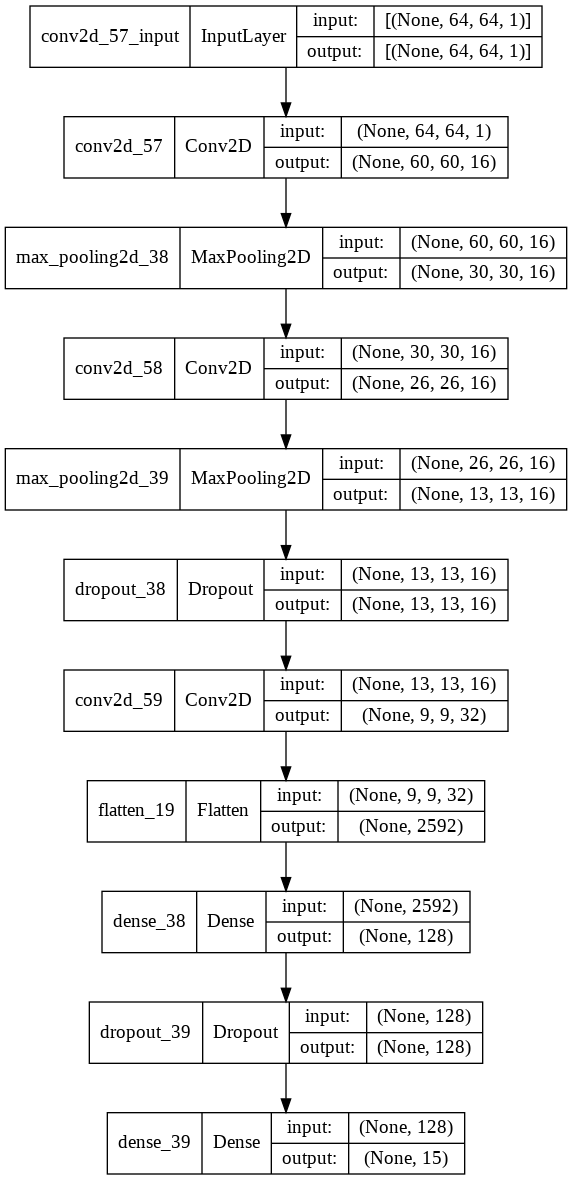

In [ ]:
visualise_model(construct_regularised_model([16, 32, 32, 256], 0.4))

In [ ]:
history = train_model(construct_regularised_model([16, 32, 32, 256], 0.4), 30)

Epoch 1/30
145/150 [============================>.] - ETA: 0s - loss: 1.5729 - accuracy: 0.5003
Epoch 00001: val_loss improved from inf to 0.67989, saving model to optimum-model.h5
150/150 [==============================] - 2s 9ms/step - loss: 1.5461 - accuracy: 0.5089 - val_loss: 0.6799 - val_accuracy: 0.7908
Epoch 2/30
149/150 [============================>.] - ETA: 0s - loss: 0.5955 - accuracy: 0.8011
Epoch 00002: val_loss improved from 0.67989 to 0.40498, saving model to optimum-model.h5
150/150 [==============================] - 1s 7ms/step - loss: 0.5934 - accuracy: 0.8019 - val_loss: 0.4050 - val_accuracy: 0.8708
Epoch 3/30
150/150 [==============================] - ETA: 0s - loss: 0.3917 - accuracy: 0.8682
Epoch 00003: val_loss improved from 0.40498 to 0.30614, saving model to optimum-model.h5
150/150 [==============================] - 1s 8ms/step - loss: 0.3917 - accuracy: 0.8682 - val_loss: 0.3061 - val_accuracy: 0.8975
Epoch 4/30
146/150 [============================>.] - ET

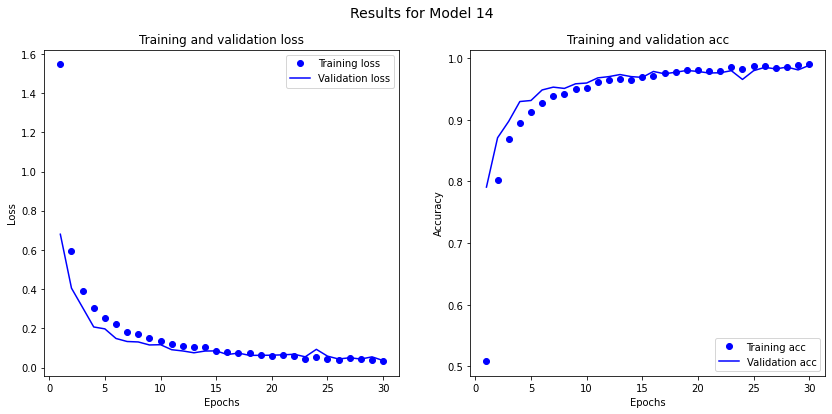

In [ ]:
plot_model_history(history, name="Model 14")

#### **Summary of Model 14**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |
| 3 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0001 | 0.2020 | 0.9546 | Although the accuracy has slightly decreased, the loss has stabilised. However, there are still signs of overfitting |
| 4 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0005 | 0.1130 | 0.9758 | Increasing the learning rate has sacrificed the stability of the loss, but the validation loss decreased and validation accuracy increased |
| 5 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.00025 | 0.1606 | 0.9625 | The model has slightly stabilised, however overfitting occurred at the 7th epoch |
| 6 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | adam | 0.0005 | 0.0984 | 0.9837 | It is clear that the Adam optimiser function performs better than the RMSProp optimiser function as an optimal validation loss/accuracy has been achieved at epoch 21 |
| 7 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0931 | 0.9721 | Validation loss has consistently decreased and reached its optimal at epoch 12. The model now looks much more stabilised with less noise |
| 8 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0639 | 0.9821 | Lowest validation loss was achieved at epoch 13. The performance of the model has improved after increasing the convolutional kernel size to (5, 5) |
| 9 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0663 | 0.9821 | Lowest validation loss was achieved at epoch 28. Overfitting has not improved since the validation loss has slightly increased and started to fluctuate |
| 10 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0474 | 0.9871 | Lowest validation loss was achieved at epoch 27. Overfitting has clearly been improved as the validation loss has decreased with a more smoothed line |
| 11 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0424 | 0.9867 | Lowest validation loss was achieved at epoch 25. Although an optimal validation loss was achieved, overfitting still needed to be improved as there were minor fluctuations with the metrics creating minor noise |
| 12 | 32, 32, 64, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0477 | 0.9837 | Lowest validation loss was achieved at epoch 29. Overfitting has improved after decreasing the network capacity. However, the validation loss could be better |
| 13 | 16, 16, 32, 64, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0572 | 0.9812 | Lowest validation loss was achieved at epoch 28. Overfitting has started to decline since the training loss is higher than the validation loss as shown on the illustrated graph plots |
| 14 | 16, 32, 32, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0354 | 0.9883 | Overfitting has been minimised slightly after re-adjusting the network capacity, and an optimal validation loss has been achieved at epoch 30 |


The outputs from model 14 shows that increasing the filters for the second 2D convolutional layer and the first dense layer back to 256 has minimised overfitting compared to the previous model. The validation loss was decreasing throughout the training process with minor instabilities as illustrated on the graph plots, and even managed to reach an optimal validation loss of 0.0354. The validation accuracy was also increasing throughout the training process, achieving an optimal accuracy of 0.9883.

Although the model no longer has a training loss that is greater than the validation loss, it still has minor instabilities that need improving. I will now be adding batch normalisation onto the model to observe whether it will regularise and further optimise the model.

In order to get the best learning and generalisation out of batch normalisation, I will be removing dropout layers from my model. According to (Brownlee, 2019), using batch normalisation along with dropout layers causes the data used to normalise the activations of the previous layer can become noisy due to the random dropping out of neurons during the dropout process. We are trying to avoid noisy data to mitigate overfitting, and therefore dropout layers will not be used with batch normalisation layers.

### **Model 15 - Add Batch Normalisation**

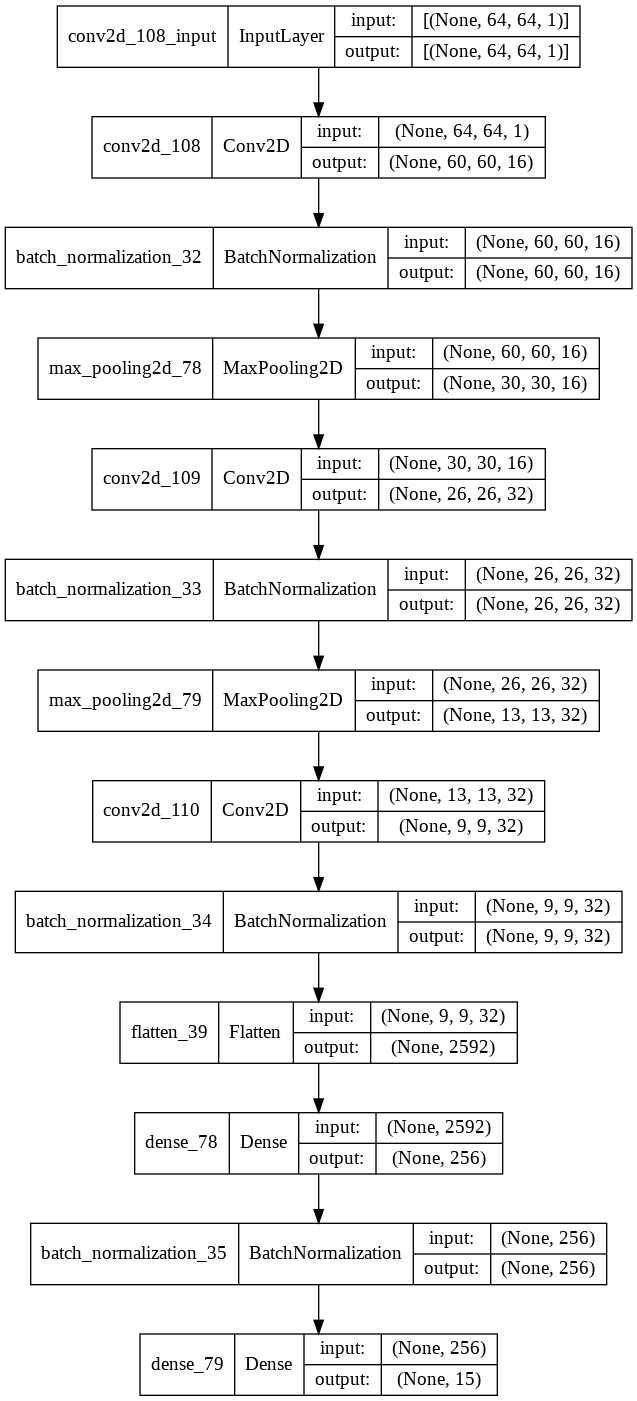

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation='tanh', input_shape=(64, 64, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='tanh'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='tanh'))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='tanh'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(15, activation='softmax'))
model.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

visualise_model(model)

In [ ]:
history = train_model(model, 30)

Epoch 1/30
146/150 [============================>.] - ETA: 0s - loss: 0.8392 - accuracy: 0.7527
Epoch 00001: val_loss improved from inf to 6.34604, saving model to optimum-model.h5
150/150 [==============================] - 2s 11ms/step - loss: 0.8239 - accuracy: 0.7571 - val_loss: 6.3460 - val_accuracy: 0.0854
Epoch 2/30
144/150 [===========================>..] - ETA: 0s - loss: 0.1552 - accuracy: 0.9590
Epoch 00002: val_loss did not improve from 6.34604
150/150 [==============================] - 1s 8ms/step - loss: 0.1533 - accuracy: 0.9593 - val_loss: 7.0956 - val_accuracy: 0.1154
Epoch 3/30
145/150 [============================>.] - ETA: 0s - loss: 0.0706 - accuracy: 0.9845
Epoch 00003: val_loss improved from 6.34604 to 4.52681, saving model to optimum-model.h5
150/150 [==============================] - 1s 9ms/step - loss: 0.0702 - accuracy: 0.9848 - val_loss: 4.5268 - val_accuracy: 0.2833
Epoch 4/30
148/150 [============================>.] - ETA: 0s - loss: 0.0307 - accuracy: 0.99

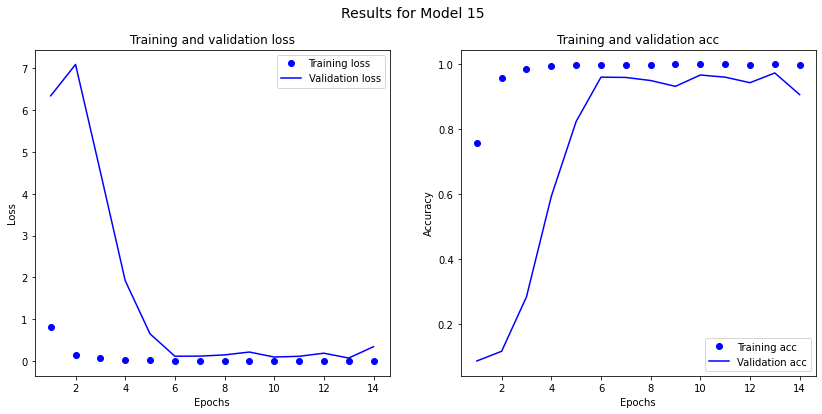

In [ ]:
plot_model_history(history, name="Model 15")

#### **Summary of Model 15**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |
| 3 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0001 | 0.2020 | 0.9546 | Although the accuracy has slightly decreased, the loss has stabilised. However, there are still signs of overfitting |
| 4 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0005 | 0.1130 | 0.9758 | Increasing the learning rate has sacrificed the stability of the loss, but the validation loss decreased and validation accuracy increased |
| 5 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.00025 | 0.1606 | 0.9625 | The model has slightly stabilised, however overfitting occurred at the 7th epoch |
| 6 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | adam | 0.0005 | 0.0984 | 0.9837 | It is clear that the Adam optimiser function performs better than the RMSProp optimiser function as an optimal validation loss/accuracy has been achieved at epoch 21 |
| 7 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0931 | 0.9721 | Validation loss has consistently decreased and reached its optimal at epoch 12. The model now looks much more stabilised with less noise |
| 8 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0639 | 0.9821 | Lowest validation loss was achieved at epoch 13. The performance of the model has improved after increasing the convolutional kernel size to (5, 5) |
| 9 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0663 | 0.9821 | Lowest validation loss was achieved at epoch 28. Overfitting has not improved since the validation loss has slightly increased and started to fluctuate |
| 10 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0474 | 0.9871 | Lowest validation loss was achieved at epoch 27. Overfitting has clearly been improved as the validation loss has decreased with a more smoothed line |
| 11 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0424 | 0.9867 | Lowest validation loss was achieved at epoch 25. Although an optimal validation loss was achieved, overfitting still needed to be improved as there were minor fluctuations with the metrics creating minor noise |
| 12 | 32, 32, 64, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0477 | 0.9837 | Lowest validation loss was achieved at epoch 29. Overfitting has improved after decreasing the network capacity. However, the validation loss could be better |
| 13 | 16, 16, 32, 64, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0572 | 0.9812 | Lowest validation loss was achieved at epoch 28. Overfitting has started to decline since the training loss is higher than the validation loss as shown on the illustrated graph plots |
| 14 | 16, 32, 32, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0354 | 0.9883 | Overfitting has been minimised slightly after re-adjusting the network capacity, and an optimal validation loss has been achieved at epoch 30 |
| 15 | 16, 32, 32, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0719 | 0.9737 | Overfitting occured after epoch 6. Lowest validation loss was achieved at epoch 13, to which EarlyStopping happened at epoch 14 as there were no improvements |


The outputs from model 15 shows that using batch normalisation was not as useful in minimising overfitting and optimisation compared to dropout layers, as it only decreased the performance of the model. The graph plot illustrations clearly show that overfitting occurred after epoch 6 causing the model to become unstable. The model only achieved an optimal validation loss of 0.0719, which is not the best compared to using a dropout layer of 0.4.

Overall, the model didn't perform well with this technique as the data points were in constant fluctuation after a certain point. Thus, I have decided to use dropout layers instead of batch normalisation, since it provides a better loss and accuracy. I will now be looking into implementing depth-wise separable convolution, an advanced technique that divides a single (conv2D) convolutional layer into two or more convolutions allowing the model to become both lighter and faster for training.

### **Model 16 - Use Depth-Wise Separable Convolution**

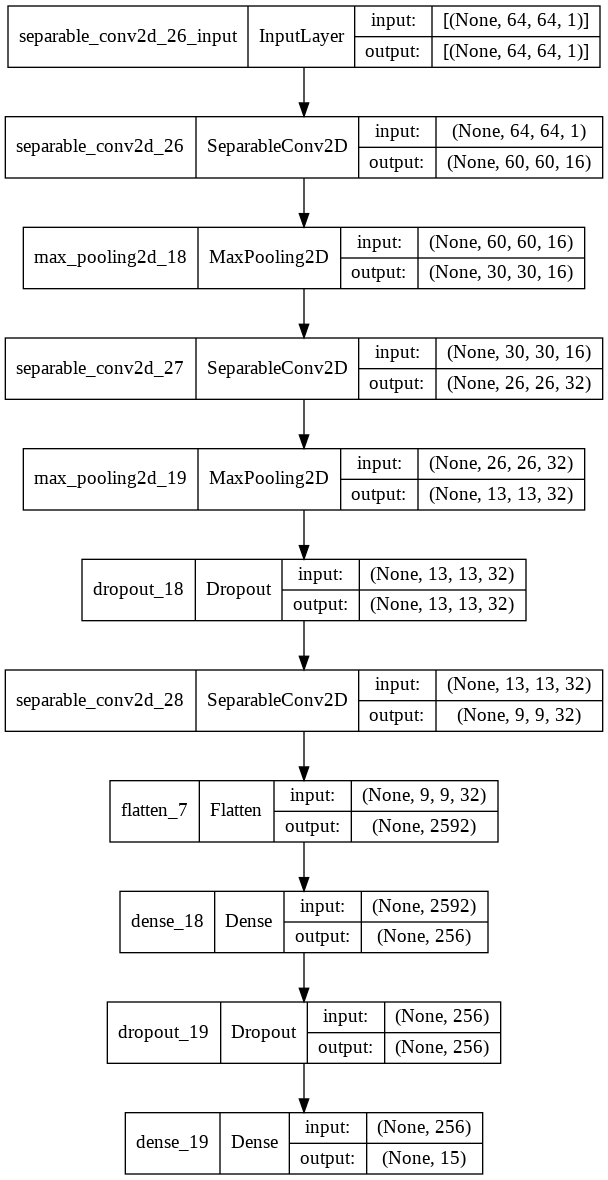

In [ ]:
model = models.Sequential()
model.add(layers.SeparableConv2D(16, (5, 5), activation='tanh', input_shape=(64, 64, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.SeparableConv2D(32, (5, 5), activation='tanh'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.SeparableConv2D(32, (5, 5), activation='tanh'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='tanh'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(15, activation='softmax'))
model.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

visualise_model(model)

In [ ]:
history = train_model(model, 30)

Epoch 1/30
149/150 [============================>.] - ETA: 0s - loss: 2.1367 - accuracy: 0.3112
Epoch 00001: val_loss improved from inf to 1.64335, saving model to best-model.h5
150/150 [==============================] - 3s 18ms/step - loss: 2.1320 - accuracy: 0.3126 - val_loss: 1.6434 - val_accuracy: 0.4908
Epoch 2/30
148/150 [============================>.] - ETA: 0s - loss: 1.3656 - accuracy: 0.5702
Epoch 00002: val_loss improved from 1.64335 to 1.08918, saving model to best-model.h5
150/150 [==============================] - 2s 16ms/step - loss: 1.3624 - accuracy: 0.5713 - val_loss: 1.0892 - val_accuracy: 0.6417
Epoch 3/30
148/150 [============================>.] - ETA: 0s - loss: 1.0026 - accuracy: 0.6732
Epoch 00003: val_loss improved from 1.08918 to 0.83635, saving model to best-model.h5
150/150 [==============================] - 2s 16ms/step - loss: 0.9999 - accuracy: 0.6737 - val_loss: 0.8364 - val_accuracy: 0.7308
Epoch 4/30
149/150 [============================>.] - ETA: 0s 

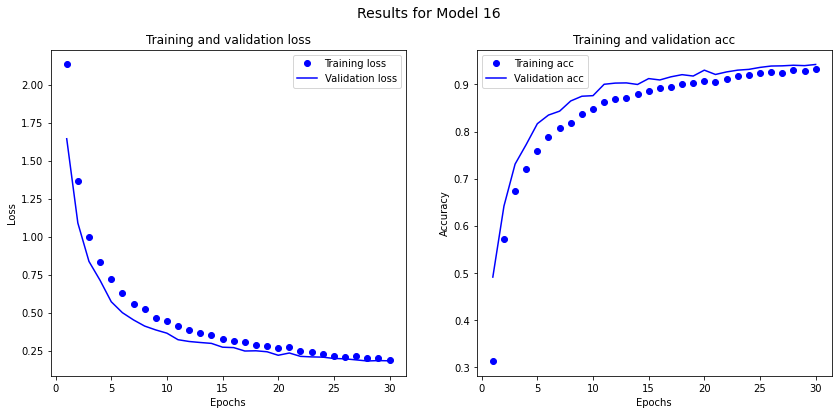

In [ ]:
plot_model_history(history, name="Model 16")

#### **Summary of Model 16**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |
| 3 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0001 | 0.2020 | 0.9546 | Although the accuracy has slightly decreased, the loss has stabilised. However, there are still signs of overfitting |
| 4 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0005 | 0.1130 | 0.9758 | Increasing the learning rate has sacrificed the stability of the loss, but the validation loss decreased and validation accuracy increased |
| 5 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.00025 | 0.1606 | 0.9625 | The model has slightly stabilised, however overfitting occurred at the 7th epoch |
| 6 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | adam | 0.0005 | 0.0984 | 0.9837 | It is clear that the Adam optimiser function performs better than the RMSProp optimiser function as an optimal validation loss/accuracy has been achieved at epoch 21 |
| 7 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0931 | 0.9721 | Validation loss has consistently decreased and reached its optimal at epoch 12. The model now looks much more stabilised with less noise |
| 8 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0639 | 0.9821 | Lowest validation loss was achieved at epoch 13. The performance of the model has improved after increasing the convolutional kernel size to (5, 5) |
| 9 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0663 | 0.9821 | Lowest validation loss was achieved at epoch 28. Overfitting has not improved since the validation loss has slightly increased and started to fluctuate |
| 10 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0474 | 0.9871 | Lowest validation loss was achieved at epoch 27. Overfitting has clearly been improved as the validation loss has decreased with a more smoothed line |
| 11 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0424 | 0.9867 | Lowest validation loss was achieved at epoch 25. Although an optimal validation loss was achieved, overfitting still needed to be improved as there were minor fluctuations with the metrics creating minor noise |
| 12 | 32, 32, 64, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0477 | 0.9837 | Lowest validation loss was achieved at epoch 29. Overfitting has improved after decreasing the network capacity. However, the validation loss could be better |
| 13 | 16, 16, 32, 64, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0572 | 0.9812 | Lowest validation loss was achieved at epoch 28. Overfitting has started to decline since the training loss is higher than the validation loss as shown on the illustrated graph plots |
| 14 | 16, 32, 32, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0354 | 0.9883 | Overfitting has been minimised slightly after re-adjusting the network capacity, and an optimal validation loss has been achieved at epoch 30 |
| 15 | 16, 32, 32, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0719 | 0.9737 | Overfitting occured after epoch 2. Lowest validation loss was achieved at epoch 13, to which EarlyStopping was run at epoch 14 due to no improvements in loss |
| 16 | 16, 32, 32, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.1816 | 0.9408 | Lowest validation loss achieved at epoch 28. Overfitting was still evident as the training loss was higher than the validation loss |


The outputs from model 16 shows that the implementing depth-wise separable convolution has overfitted yet again and scaled down the performance of the model, given the training accuracy has a slight increase in training loss compared to the validation loss. The model was able to achieve an optimal validation loss of 0.1816 and a validation accuracy of 0.9408. Compared to other model iterations, this was below average. Thus, the model has failed in improving from its previous iterations and will not be used the final production model since it won't be an optimal model.

I will now be experimenting with data augmentation, to help mitigate the overfitting problem at hand. This procedure will involve generating more training data from the existing training samples by performing random transformations to the images in the training set (e.g. rotating, stretching, flipping), and using those to train the model. The aim of this procedure is for the model to never be able to identify an image as exactly the same as another. By augmenting the datam it will then expose the model to more attributes of the training data and improve its ability to generalise.

### **Model 17 - Use Data Augmentation Generators**

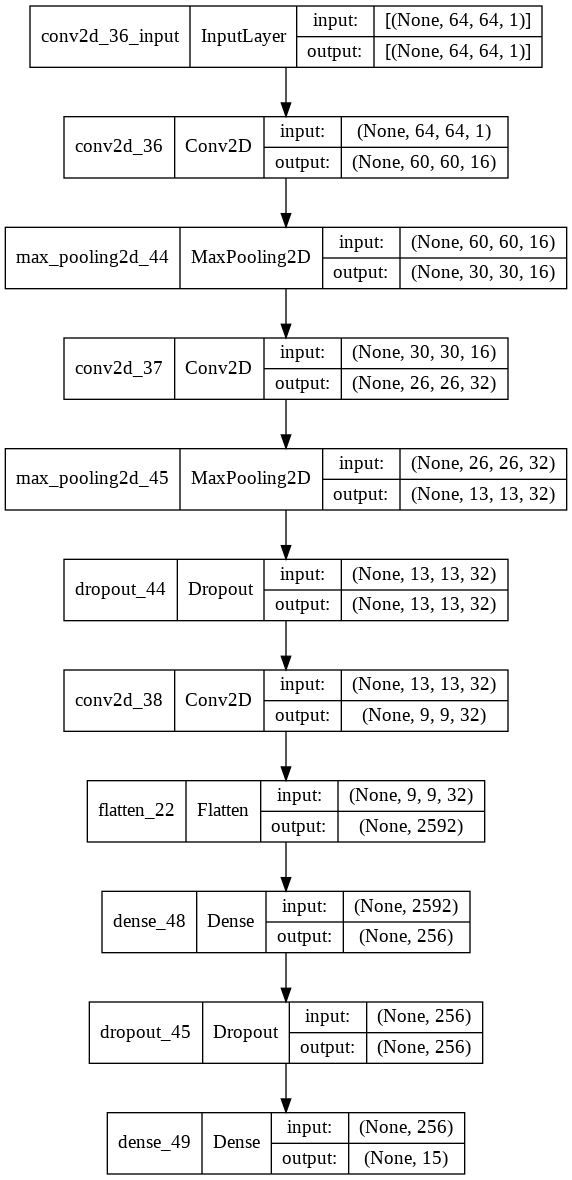

In [ ]:
model = construct_regularised_model([16, 32, 32, 256], 0.4)
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

visualise_model(model)

In [ ]:
history = train_augmented_model(model, train_datagen, 50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
149/150 [============================>.] - ETA: 0s - loss: 2.3789 - accuracy: 0.1840
Epoch 00001: val_loss improved from inf to 2.18278, saving model to best-model.h5
150/150 [==============================] - 8s 49ms/step - loss: 2.3773 - accuracy: 0.1842 - val_loss: 2.1828 - val_accuracy: 0.2529
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 1.7729 - accuracy: 0.3667
Epoch 00002: val_loss improved from 2.18278 to 1.04174, saving model to best-model.h5
150/150 [==============================] - 7s 47ms/step - loss: 1.7729 - accuracy: 0.3667 - val_loss: 1.0417 - val_accuracy: 0.6483
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 1.5489 - accuracy: 0.4436
Epoch 00003: val_loss improved from 1.04174 to 0.97441, saving model to best-model.h5
150/150 [==============================] - 7s 47ms/step - loss: 1.5489 - accuracy: 0.4436 - val_loss: 0.9744 - val_accuracy: 0.6592
Epoch 4/50
149/150 [============================>.] - ETA: 0s 

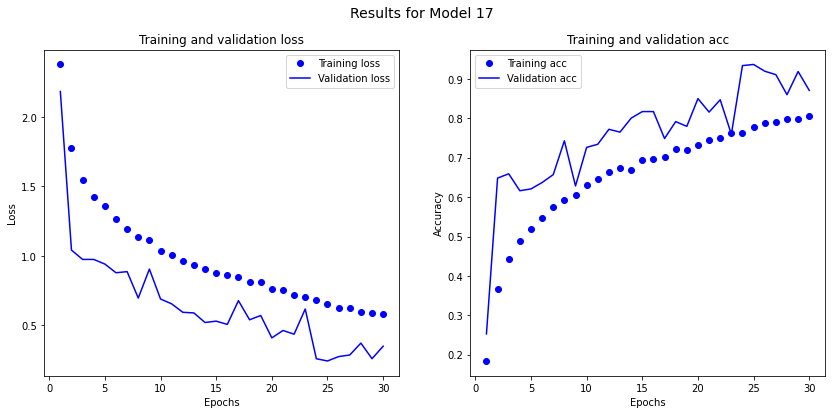

In [ ]:
plot_model_history(history, name="Model 17")

#### **Summary of Model 17**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |
| 3 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0001 | 0.2020 | 0.9546 | Although the accuracy has slightly decreased, the loss has stabilised. However, there are still signs of overfitting |
| 4 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0005 | 0.1130 | 0.9758 | Increasing the learning rate has sacrificed the stability of the loss, but the validation loss decreased and validation accuracy increased |
| 5 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.00025 | 0.1606 | 0.9625 | The model has slightly stabilised, however overfitting occurred at the 7th epoch |
| 6 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | adam | 0.0005 | 0.0984 | 0.9837 | It is clear that the Adam optimiser function performs better than the RMSProp optimiser function as an optimal validation loss/accuracy has been achieved at epoch 21 |
| 7 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0931 | 0.9721 | Validation loss has consistently decreased and reached its optimal at epoch 12. The model now looks much more stabilised with less noise |
| 8 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0639 | 0.9821 | Lowest validation loss was achieved at epoch 13. The performance of the model has improved after increasing the convolutional kernel size to (5, 5) |
| 9 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0663 | 0.9821 | Lowest validation loss was achieved at epoch 28. Overfitting has not improved since the validation loss has slightly increased and started to fluctuate |
| 10 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0474 | 0.9871 | Lowest validation loss was achieved at epoch 27. Overfitting has clearly been improved as the validation loss has decreased with a more smoothed line |
| 11 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0424 | 0.9867 | Lowest validation loss was achieved at epoch 25. Although an optimal validation loss was achieved, overfitting still needed to be improved as there were minor fluctuations with the metrics creating minor noise |
| 12 | 32, 32, 64, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0477 | 0.9837 | Lowest validation loss was achieved at epoch 29. Overfitting has improved after decreasing the network capacity. However, the validation loss could be better |
| 13 | 16, 16, 32, 64, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0572 | 0.9812 | Lowest validation loss was achieved at epoch 28. Overfitting has started to decline since the training loss is higher than the validation loss as shown on the illustrated graph plots |
| 14 | 16, 32, 32, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0354 | 0.9883 | Overfitting has been minimised slightly after re-adjusting the network capacity, and an optimal validation loss has been achieved at epoch 30 |
| 15 | 16, 32, 32, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0719 | 0.9737 | Overfitting occured after epoch 2. Lowest validation loss was achieved at epoch 13, to which EarlyStopping was run at epoch 14 due to no improvements in loss |
| 16 | 16, 32, 32, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.1816 | 0.9408 | Lowest validation loss achieved at epoch 28. Overfitting was still evident as the training loss was higher than the validation loss |
| 17 | 16, 32, 32, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.2437 | 0.9367 | Lowest validation loss achieved at epoch 25. Overfitting was still evident as the training loss was higher than the validation loss, to which EarlyStopping was run at epoch 30 |


The outputs from model 17 shows that using data augmentation has overfitted the model as well as scaled it down, given that the training accuracy had a higher validation loss compared to the validation loss as illustrated on the graph plots. The model achieved an optimal validation loss of 0.2437, which is the highest validation loss compared to the other model iterations. This could be due to not incorporating enough parameters in the data augmentation generator. Thus, the model may have failed to produce enough unique samples to identify the different attributes of data.

I will now be tweaking the data augmentation generator to observe whether the overfitting can be improved.

### **Model 18 - Configure the parameters in the Data Augmentation Generator**

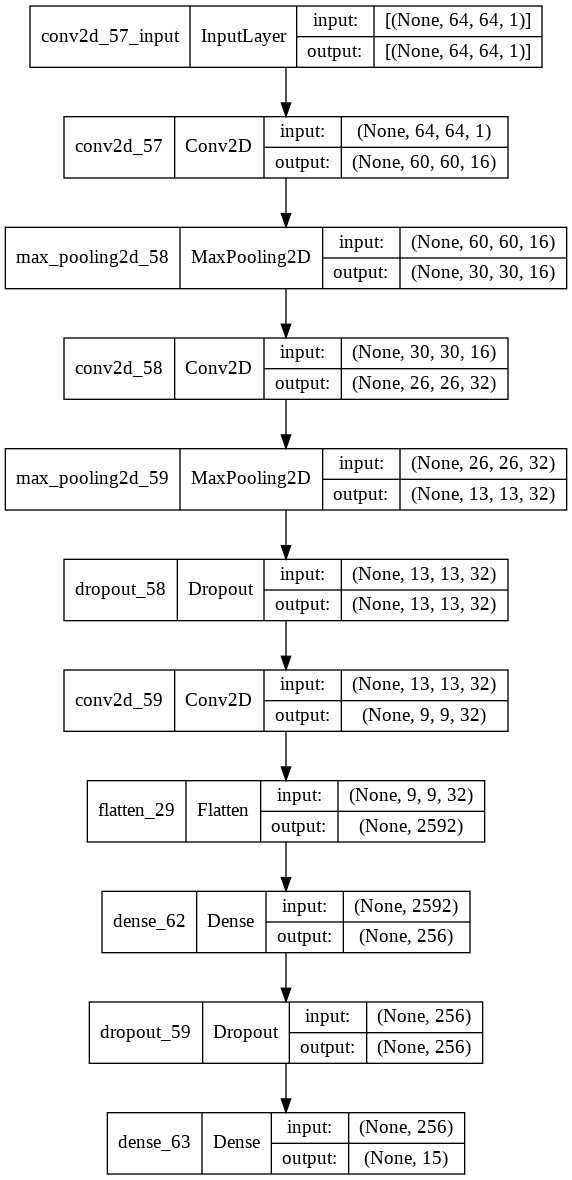

In [ ]:
model = construct_regularised_model([16, 32, 32, 256], 0.4)
train_datagen = ImageDataGenerator(
    rotation_range=35,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.4,
    zoom_range=0.4,
    fill_mode='nearest'
)

visualise_model(model)

In [ ]:
history = train_augmented_model(model, train_datagen, 50)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
149/150 [============================>.] - ETA: 0s - loss: 2.3540 - accuracy: 0.2049
Epoch 00001: val_loss improved from inf to 1.62349, saving model to best-model.h5
150/150 [==============================] - 8s 49ms/step - loss: 2.3505 - accuracy: 0.2059 - val_loss: 1.6235 - val_accuracy: 0.3917
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 1.7313 - accuracy: 0.3956
Epoch 00002: val_loss improved from 1.62349 to 1.01015, saving model to best-model.h5
150/150 [==============================] - 7s 47ms/step - loss: 1.7313 - accuracy: 0.3956 - val_loss: 1.0102 - val_accuracy: 0.6583
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 1.5345 - accuracy: 0.4545
Epoch 00003: val_loss improved from 1.01015 to 0.96512, saving model to best-model.h5
150/150 [==============================] - 7s 47ms/step - loss: 1.5345 - accuracy: 0.4545 - val_loss: 0.9651 - val_accuracy: 0.6458
Epoch 4/50
149/150 [============================>.] - ETA: 0s 

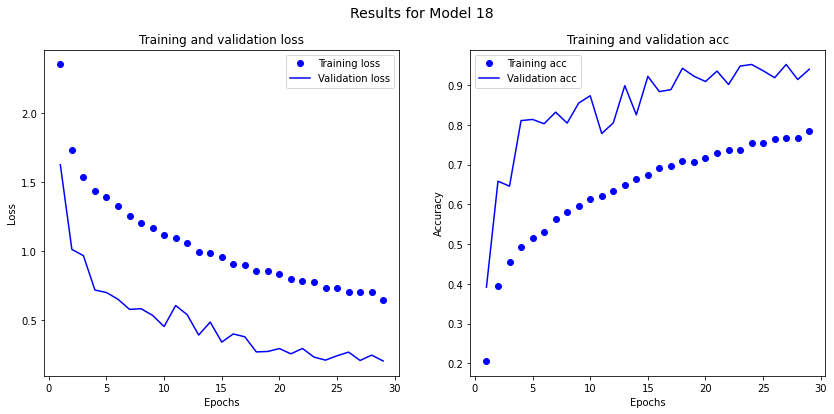

In [ ]:
plot_model_history(history, name="Model 18")

#### **Summary of Model 18**

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|Comments|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|:----------------------------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 | The baseline model has been exceeded, however there are clear signs of overfitting |
| 2 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.1368 | 0.9771 | A higher validation accuracy has been achieved, however overfitting started to occur after epoch 6 causing the validation loss to drastically increase |
| 3 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0001 | 0.2020 | 0.9546 | Although the accuracy has slightly decreased, the loss has stabilised. However, there are still signs of overfitting |
| 4 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.0005 | 0.1130 | 0.9758 | Increasing the learning rate has sacrificed the stability of the loss, but the validation loss decreased and validation accuracy increased |
| 5 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.00025 | 0.1606 | 0.9625 | The model has slightly stabilised, however overfitting occurred at the 7th epoch |
| 6 | 64, 64, 128, 512, 15 | relu, relu, relu, relu, softmax | adam | 0.0005 | 0.0984 | 0.9837 | It is clear that the Adam optimiser function performs better than the RMSProp optimiser function as an optimal validation loss/accuracy has been achieved at epoch 21 |
| 7 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0931 | 0.9721 | Validation loss has consistently decreased and reached its optimal at epoch 12. The model now looks much more stabilised with less noise |
| 8 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0639 | 0.9821 | Lowest validation loss was achieved at epoch 13. The performance of the model has improved after increasing the convolutional kernel size to (5, 5) |
| 9 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0663 | 0.9821 | Lowest validation loss was achieved at epoch 28. Overfitting has not improved since the validation loss has slightly increased and started to fluctuate |
| 10 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0474 | 0.9871 | Lowest validation loss was achieved at epoch 27. Overfitting has clearly been improved as the validation loss has decreased with a more smoothed line |
| 11 | 64, 64, 128, 512, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0424 | 0.9867 | Lowest validation loss was achieved at epoch 25. Although an optimal validation loss was achieved, overfitting still needed to be improved as there were minor fluctuations with the metrics creating minor noise |
| 12 | 32, 32, 64, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0477 | 0.9837 | Lowest validation loss was achieved at epoch 29. Overfitting has improved after decreasing the network capacity. However, the validation loss could be better |
| 13 | 16, 16, 32, 64, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0572 | 0.9812 | Lowest validation loss was achieved at epoch 28. Overfitting has started to decline since the training loss is higher than the validation loss as shown on the illustrated graph plots |
| 14 | 16, 32, 32, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0354 | 0.9883 | Overfitting has been minimised slightly after re-adjusting the network capacity, and an optimal validation loss has been achieved at epoch 30 |
| 15 | 16, 32, 32, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0719 | 0.9737 | Overfitting occured after epoch 2. Lowest validation loss was achieved at epoch 13, to which EarlyStopping was run at epoch 14 due to no improvements in loss |
| 16 | 16, 32, 32, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.1816 | 0.9408 | Lowest validation loss achieved at epoch 28. Overfitting was still evident as the training loss was higher than the validation loss |
| 17 | 16, 32, 32, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.2437 | 0.9367 | Lowest validation loss achieved at epoch 25. Overfitting was still evident as the training loss was higher than the validation loss, to which EarlyStopping was run at epoch 30 |
| 18 | 16, 32, 32, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.2016 | 0.9400 | Lowest validation loss achieved at epoch 29. Overfitting was marginally improved, however, the training loss was still higher than the validation loss. EarlyStopping was also run at epoch 29 |


The outputs from model 18 shows that configuring the parameters in the data augmentation generator has slighly improved the performance of the model compared to the previous model iteration. However, the model is still showing major signs of overfitting with some noise on the graph plots. The training loss is still higher than the validation loss (which is a clear sign of overfitting). The model achieved an optimal validation loss of 0.2016, which shows that configuring the generator with increased parameter values has had a somewhat of an improvement on the accuracy of the model. While these results are satisfactory, incorporating them on the final production model will not be reliable due the data points being in constant fluctuation. Thus, we can conclude that data augmentation will not be used on the final production model.

I will now be evaluating the results produced from all the model iterations. This will enable me to choose an optimal model which will then be used as the final production model for testing and evaluating unseen data.



## **Results**<a id="results"></a>

### **Summary of Final Production Model** <a id="summary"></a>

|Model ID| Units|Activations|Optimiser|Learning Rate|Validation Loss|Validation Acc|
|:-----:|:-------:|:-------:|:------:|:---:|:----:|:-------:|
| 1 | 16, 16, 16, 8, 15 | relu, relu, relu, relu, softmax | rmsprop | 0.001 | 0.2221 | 0.9467 |
| 14 | 16, 32, 32, 256, 15 | tanh, tanh, tanh, tanh, softmax | adam | 0.0005 | 0.0354 | 0.9883 |


After carefully analysing all the model iterations, it is clear that model 14 is the most optimal model for final production. This is mainly due to the fact that it produced the lowest validation loss of 0.0354 and highest validation accuracy of 0.9883 whilst also minimising overfitting. Based on the comparison of optimisers, we can conclude that the `adam` is a more suitable optimiser for multi-classification problems than `rmsprop`. Compared to model 1, the final results have shown a huge improvement in both loss and accuracy. This proves how powerful both regularisation and tuning hyperparameters.

### **Final Production Model Evaluation** <a id="evaluation"></a>

In [ ]:
# load the model
# model = model.load_weights("best-model_98.h5")

# build final model
model = construct_regularised_model([16, 32, 32, 256], 0.4)

# train final model
model.fit(train_x, 
          train_y,
          epochs=30,
          batch_size=64)

# evaluate final model with the test data
test_results = model.evaluate(test_x, test_y)
print(test_results)

Epoch 1/30
150/150 [==============================] - 9s 6ms/step - loss: 1.5984 - accuracy: 0.4934
Epoch 2/30
150/150 [==============================] - 1s 5ms/step - loss: 0.5971 - accuracy: 0.7992
Epoch 3/30
150/150 [==============================] - 1s 6ms/step - loss: 0.3671 - accuracy: 0.8785
Epoch 4/30
150/150 [==============================] - 1s 5ms/step - loss: 0.2818 - accuracy: 0.9066
Epoch 5/30
150/150 [==============================] - 1s 5ms/step - loss: 0.2387 - accuracy: 0.9164
Epoch 6/30
150/150 [==============================] - 1s 5ms/step - loss: 0.1972 - accuracy: 0.9317
Epoch 7/30
150/150 [==============================] - 1s 5ms/step - loss: 0.1673 - accuracy: 0.9424
Epoch 8/30
150/150 [==============================] - 1s 5ms/step - loss: 0.1408 - accuracy: 0.9511
Epoch 9/30
150/150 [==============================] - 1s 5ms/step - loss: 0.1385 - accuracy: 0.9523
Epoch 10/30
150/150 [==============================] - 1s 6ms/step - loss: 0.1178 - accuracy: 0.9593

On the cell above, I have re-constructed final model for the purpose of evaluating it on unseen test data. The results show that the final model achieved a final loss of 0.067 whilst also achieving a final accuracy of 0.98 (98%). 

In [ ]:
model.save("best-model_98.h5")

### **Final Production Model Predictions** <a id="predictions"></a>

The cell below shows the comparisons between the predicted Chinese characters and the actual Chinese characters

In [ ]:
Predictions = model.predict(test_x)

In [ ]:
data = []
predicted = np.argmax(Predictions, axis=1)
actual = np.argmax(test_y.values, axis=1)
table = PrettyTable(['Predicted Data', 'Actual Data'])

# 1: 零
# 2: 一
# 3: 二
# 4: 三
# 5: 四
# 6: 五
# 7: 六
# 8: 七
# 9: 八
# 10: 九
# 11: 十
# 12: 百
# 13: 千
# 14: 万
# 15: 亿

for i in range(20):
  data.append([predicted[i], actual[i]])
for record in data:
  table.add_row(record)
print(table)

+----------------+-------------+
| Predicted Data | Actual Data |
+----------------+-------------+
|       8        |      8      |
|       13       |      13     |
|       8        |      8      |
|       11       |      11     |
|       9        |      9      |
|       13       |      13     |
|       13       |      13     |
|       10       |      10     |
|       4        |      4      |
|       10       |      10     |
|       7        |      7      |
|       11       |      11     |
|       6        |      6      |
|       1        |      1      |
|       6        |      6      |
|       1        |      1      |
|       5        |      5      |
|       4        |      4      |
|       13       |      13     |
|       8        |      8      |
+----------------+-------------+


九



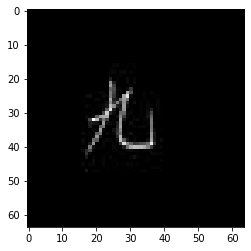

In [ ]:
display_sample_image(test_x[8])
print(f"{df.character[np.argmax(test_y.values, axis=1)[8]]}\n")

The prediction output above shows that the final model has successully been able to predict a Chinese handwritten character with its respective label.

## **Conclusion** <a class="anchor" id="conclusion"></a>

Overall, a total of 18 iterations were made to the baseline model to achieve a final production model that could accurately predict handwritten Chinese characters, with a validation accuracy of 98%. I believe I have been able to successfully solve the computer vision problem by following the DLWP workflow, and experimenting with DL techniques as well as using advanced best practices e.g. ModelCheckpoint, EarlyStopping.

The final model has proven my hypthoses to be  to be true: the outputs can be predicted based on the given inputs, and the availability of data is adequately useful to study the relationship between the inputs and outputs. This was evident when it came to evaluating the model and outputting the predictions with their respestive labels.

**Future Research**

For future research, to achieve a more reliable and accurate model, it would be ideal to follow a more systematic approach to hyperparameter optimisation e.g. using techniques Bayesian optimisation or genetic algorithms to make use of validation performance history with a set of hyperparameters as inputs, and select the next set of hyperparameters to evaluate on. This would allow intelligent decisions to be made rather than relying on intuition and making arbitrary decisions.

## **References** <a class="anchor" id="references"></a>

- Chollet, F: "Deep Learning with Python", 2018
- Preda, G: Chinese MNIST, Kaggle, 2021
- Tkt, N: MNIST Chinese Characters with TensorFlow Notebook, Kaggle, 2021
- Rahman, S: Artificial Intelligence: CW1 - Follow the universal workflow of DLWP 4.5, 2021
- Brownlee, J: Deep Learning Performance: A Gentle Introduction to Batch Normalization, 2019